In [6]:
from scipy.stats import norm

In [1]:
import numpy as np
import pandas as pd
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian

from scipy.integrate import quad
from scipy.stats import norm
from numba import jit
from scipy import interpolate
import matplotlib.pyplot as plt


In [8]:
norm.cdf(1)

0.8413447460685429

In [124]:
def g_n(x):
    return norm.pdf(x,0,1)
def FX_lock1(X,m,g=g_n):
    integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x))
    
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(a>1.193,1,b)

    omega_p = b*X
    
    A = omega_p/X

    if abs(A)<=1:
        theta_p = np.arcsin(A)
        I_l,err = quad(integrand_lock,-theta_p,theta_p,limit=200)
        return I_l
    else: 
        theta_p = np.arcsin(A)
        I_l,err = quad(integrand_lock,-np.pi/2,np.pi/2,limit=200)
        return I_l

def FX_drift1(X,m,g=g_n):
    if m == 0:
        return 0
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(a>1.193,1,b)

    O_p = b*X
    # O_p = (4/np.pi)*np.sqrt(X/m)

    integrand_drift = lambda x:1/(m*x**2+1/m)*g(x)
    I_d,err = quad(integrand_drift,O_p,np.inf,limit=200)
    return -1*I_d

def FX_0(X,m,O_0,g=g_n):
        O_d = min(O_0,X)
        theta_0 = np.arcsin(O_d/X)
        integrand_l = lambda x:np.cos(x)**2*g(X*np.sin(x))
        integrand_d = lambda x:(1/x**2)*g(x)
        I_l,err_l = quad(integrand_l,-theta_0,theta_0,limit=200) #lock
        I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift
        Fl = 1*I_l
        Fd = - 1/(m)*I_d
        F0 = Fl + Fd
        return F0,Fl,Fd
get_FX_l1 = np.vectorize(FX_lock1)
get_FX_d1 = np.vectorize(FX_drift1)
get_FX_0 = np.vectorize(FX_0)


def g_sec(x,Or,Om):
    g = norm.pdf(x,-Or,1)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

def get_O_r(r):
    r_s = np.linspace(r/2+0.5,1,5000,endpoint=False)
    A = norm.ppf(r_s)
    return np.mean(A)

def F_lock22(r,K,m,F_R0, g=g_sec):
    X = K*r
    r_0 = F_R0(K)
    O_pm = norm.ppf(r_0/2+0.5)
    O_r = get_O_r(r_0)
    shift_O = -(K**2*r*r_0)/(2*(O_pm)**2)/m -(K**2*r*r)/(8*(O_pm)**2)/m 
    # O_pm_shift = O_pm -shift_O
    # shift = -(K**2*r*r_0)/(2*(O_pm_shift)**2)/m -(K**2*r*r)/(8*(O_pm_shift)**2)/m 
    integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x)+shift_O,O_r,O_pm)
    O_p = (4/np.pi)*np.sqrt(X/m)

    A = O_p/X
    if abs(A)<=1:
        theta_p = np.arcsin(A)
        I_l,err = quad(integrand_lock,-theta_p,theta_p,limit=200)
        return I_l
    else: 
        I_l,err = quad(integrand_lock,-np.pi/2,np.pi/2,limit=200)
        return I_l    
def F_drift22(r,K,m,F_R0,g=g_sec):
    X = K*r
    r_0 = F_R0(K)
    O_pm = norm.ppf(r_0/2+0.5)
    O_r = get_O_r(r_0)
    O_p = (4/np.pi)*np.sqrt(X/m)
    shift_O = -(K**2*r*r_0)/(2*(O_pm)**2)/m -(K**2*r*r)/(8*(O_pm)**2)/m 
    # O_pm_shift = O_pm -shift_O
    # shift = -(K**2*r*r_0)/(2*(O_pm_shift)**2)/m -(K**2*r*r)/(8*(O_pm_shift)**2)/m 

    integrand_drift = lambda x:1/(2*x**2)*g(x+shift_O,O_r,O_pm)
    I_d,err = quad(integrand_drift,O_p,np.inf,limit=200)
    # I_dm,err = quad(integrand_drift,-np.inf,-O_p,limit=200)
    return -1/(m)*(I_d)#+I_dm)
def F_sec(r,K,m,F_R0,g=g_sec):
    F_l2 = F_lock22(r,K,m,F_R0, g)
    F_d2 = F_drift22(r,K,m,F_R0, g)
    return F_l2+F_d2

get_Fp_l = np.vectorize(F_lock22)
get_Fp_d = np.vectorize(F_drift22)
get_F2 = np.vectorize(F_sec)


def Make_R_function(m,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    RX_l1 = X*get_FX_l1(X,m,g=g_n)
    RX_d1 = X*get_FX_d1(X,m,g=g_n)
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    return F_RMd,F_RMu,F_R0d,F_R0u

def Make_R0_function(m,O_0,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    F0,Fl,Fd = get_FX_0(X,m,O_0,g=g_n)
    RX_l1 = X*Fl
    RX_d1 = X*Fd
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    return F_RMd,F_RMu,F_R0d,F_R0u

def get_r_sec2(K,m,FR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    if K == 0:
        return r_sd,r_su,r_su_d,r_su_l
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2 = get_F2(r_test,K,m,FR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,10000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    r_su_l = r_su*K*F_lock22(r_su,K,m,F_R0=FR,g=g_sec)
    r_sd_l = r_sd*K*F_lock22(r_sd,K,m,F_R0=FR,g=g_sec)
    return r_sd,r_su,r_sd_l,r_su_l

get_r_sec_np2 = np.vectorize(get_r_sec2)

In [59]:
def F_lock22(r,K,m,F_R0, g=g_sec):
    X = K*r
    r_0 = F_R0(K)
    O_pm = norm.ppf(r_0/2+0.5)
    O_r = get_O_r(r_0)
    # shift = -(K**2*r*r_0)/(2*(O_pm)**2)/m - (K**2*r*r)/(8*(O_pm)**2)/m 
    shift = lambda x: -(K**2*r*r_0)/(2*(O_r+X*np.sin(x))**2)/m - (K**2*r*r)/(8*(O_r+X*np.sin(x))**2)/m

    integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x)+shift(x),O_r,O_pm)
    # integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x),O_r,O_pm)
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(a>1.193,1,b)
    O_p = b*X
    
    A = O_p/X
    A = np.where(abs(A)<=1,A,1)
    # if abs(A)<=1:
    theta_p = np.arcsin(A)
    I_l,err = quad(integrand_lock,-theta_p,theta_p,limit=200)
    return I_l
    

def F_sec2(r,K,m,F_R0,g=g_sec):
    F_l2 = F_lock2(r,K,m,F_R0, g)
    F_d2 = 0#F_drift2(r,K,m,F_R0, g)
    return F_l2+F_d2


get_Fp_l2 = np.vectorize(F_lock22)
get_F22 = np.vectorize(F_sec2)
from scipy import interpolate
def get_r_sec2(K,m,FR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    if K == 0:
        return r_sd,r_su,r_su_d,r_su_l
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2 = get_F22(r_test,K,m,FR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,10000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    r_su_l = r_su*K*F_lock22(r_su,K,m,F_R0=FR,g=g_sec)
    r_sd_l = r_sd*K*F_lock22(r_sd,K,m,F_R0=FR,g=g_sec)
    return r_sd,r_su,r_sd_l,r_su_l

get_r_sec_np2 = np.vectorize(get_r_sec2)


In [63]:
import TO_sim.analytical.order_sec_parameter as OSP


In [81]:
m = 5.5
F_RMd,F_RMu,F_R0d,F_R0u =  Make_R_function(m)
Ks_check2 = np.arange(2,6,0.1)
# rs_d3,rs_u3,rs_dFl3,rs_uFl3 = get_r_sec_np2(Ks_check2,m,F_R0u,samples=200)


In [83]:
F_RMd2,F_RMu2,F_R0d2,F_R0u2 =  OSP.Make_R_function(m)

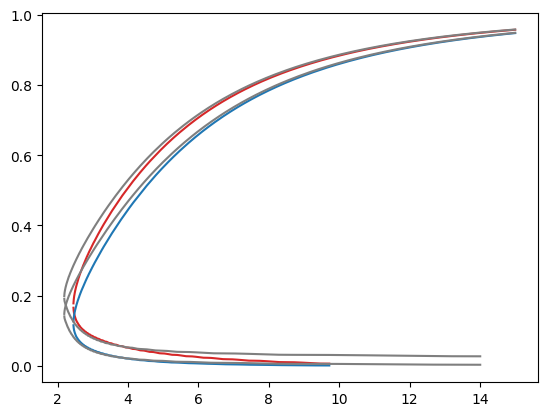

In [86]:
K_ = np.linspace(0,15,10000)
plt.plot(K_,F_R0d(K_),color='tab:red')
plt.plot(K_,F_R0u(K_),color='tab:red')
plt.plot(K_,F_RMd(K_),color='tab:blue')
plt.plot(K_,F_RMu(K_),color='tab:blue')

plt.plot(K_,F_RMd2(K_),color='tab:grey')
plt.plot(K_,F_RMu2(K_),color='tab:grey')

plt.plot(K_,F_R0d2(K_),color='tab:grey')
plt.plot(K_,F_R0u2(K_),color='tab:grey')

In [ ]:
# rs_d2,rs_u2,rs_dFl2,rs_uFl2 = get_r_sec_np(Ks_check2,m,F_R0u,samples=100)

In [ ]:
rs_d3,rs_u3,rs_dFl3,rs_uFl3 = get_r_sec_np2(Ks_check2,m,F_R0u,samples=200)


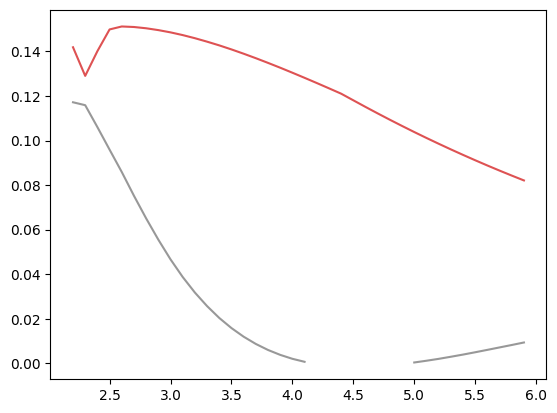

In [61]:
# plt.plot(Ks_check2,rs_dFl2,color='tab:grey')
# plt.plot(Ks_check2,rs_uFl2,color='tab:red')

plt.plot(Ks_check2,rs_dFl3,color='tab:grey',alpha=0.8)
plt.plot(Ks_check2,rs_uFl3,color='tab:red',alpha=0.8)

In [41]:
rMt438= np.array([0.019406867,0.020722266,0.018413989,0.018403741,0.017038793,0.013238055,0.018679685,0.01473135,0.01561022,0.014388955,0.015492896,0.014429656,0.013533199,0.012612161,0.013993287,0.014136052,0.015435954,0.013805765,0.012942475,0.015522182,0.012952873,0.013353188,0.013582684,0.013644973,0.013354182,0.01175315,0.013640055,0.012382347,0.013107056,0.012951946,0.012562106,0.014184554,0.011222844,0.015439618,0.013545629,0.010986628,0.014207241,0.013865026,0.015818376,0.014575855,0.013457203,0.012830302,0.012837889,0.013465615,0.016628576,0.020092076,0.013558967,0.015493202,0.017346107,0.029125943,0.023294349,0.024278729,0.023875998,0.042548711,0.045423925,0.048296852,0.049299816,0.04978734,0.051029435,0.050346607,0.020817728,0.019906145,0.019085154,0.01979519,0.019303961,0.01806596,0.018161892,0.017619628,0.017170695,0.015773713,0.016612122,0.01646907,0.015601511,0.013810719,0.014297189,0.014250949,0.013983947,0.014146111,0.013919584,0.012325232,0.012268585,0.012718166,0.012643088,0.012067499,0.011756952,0.012304061,0.011571858,0.011526855,0.010886583,0.010981493,0.010294736,0.01037492,0.009819665,0.009664553,0.00933766,0.009601137,0.00978733,0.009210046,0.008477519,0.008631298,0.007802616,0.008445185,0.008655785,0.008266534,0.006483,0.007643856,0.007900246,0.006893774,0.006935902,0.007150152,0.00715529,0.006586128,0.006797654,0.005779657,0.00595423,0.006456816,0.006220216,0.005914185,0.005912468,0.005952055,0.005578732,0.005475276,0.005829946,0.005287704,0.005063555,0.005248785,0.005094982,0.00490787,0.005229491,0.004815326,0.004927816,0.004899739,0.004415427,0.004618246,0.004571841,0.004611702,0.004224007,0.004290041,0.003925013,0.004014108,0.003966919,0.003917458,0.003762472,0.003716797,0.003671664,0.003763017,0.003341392,0.003478076,0.003520413,0.003595959,0.003516796])

In [11]:
Ks = np.arange(0,15.05,0.1)

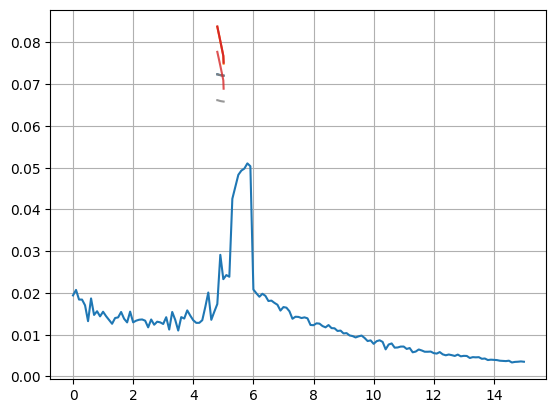

In [66]:

plt.plot(Ks_check2,rs_d2,color='tab:blue')
plt.plot(Ks_check2,rs_u2,color='tab:orange')


plt.plot(Ks_check2,rs_dFl2,color='tab:grey')
plt.plot(Ks_check2,rs_uFl2,color='tab:red')


plt.plot(Ks_check2,rs_dFl3,color='tab:grey',alpha=0.8)
plt.plot(Ks_check2,rs_uFl3,color='tab:red',alpha=0.8)

plt.plot(Ks,rMt438)
plt.grid()
# plt.ylim(0.05)

# 여러 앙상블을 통해서 확인
2차 클러스터가 형성되는 것은 + cluster의 order parameter가 이론적인 branch에 존재하기 떄문이다. 만일 이 Branch에 도달하지 못하였다면 메인 클러스터만 형성될것이다.  
여러 앙상블을 통해서 secondary cluster의 형성이 어떻게 되는지 확인해 보자

In [1]:
import TO_sim.Q_simul as QSIM

In [ ]:
QSIM.Q_Normal(N=500,m)

In [ ]:
r_clu_info['r_clu'].keys()

dict_keys(['0', '-', '+', '+_total', '-_total'])

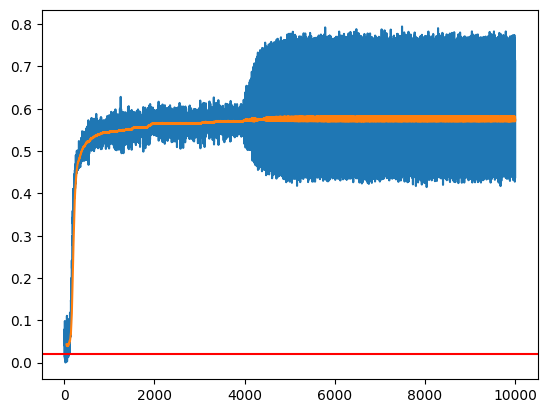

In [ ]:
plt.plot(sol['t'],sol['rs'])
plt.plot(r_clu_info['t_mean'],r_clu_info['r_total_mean'])
plt.axhline(F_RMd(K),color='red')

In [ ]:
rs_d,rs_u,rs_dF,rs_uF = get_r_sec_np2(K,m,F_R0u,samples=30)

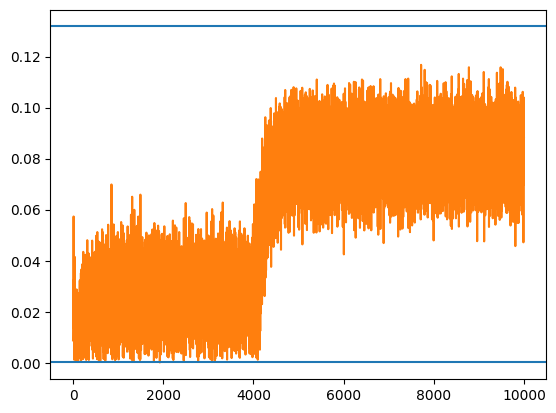

In [ ]:
plt.plot(r_clu_info['t_mean'],r_clu_info['r_clu_mean']['+'])
plt.plot(r_clu_info['t'],r_clu_info['r_clu']['+_total'])
plt.axhline(rs_dF)
plt.axhline(rs_uF)
# plt.plot(r_clu_info['t'],r_clu_info['t'])

In [14]:
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import numpy as np
import TO_sim.Q_simul as QSIM
from tqdm.notebook import tqdm

In [3]:
N = 500

In [104]:
m = 5.5
F_RMd,F_RMu,F_R0d,F_R0u =  Make_R_function(m)
Ks_check2 = np.arange(0,15,0.1)
rs_d3,rs_u3,rs_dFl3,rs_uFl3 = get_r_sec_np2(Ks_check2,m,F_R0u,samples=50)


In [68]:
rs_d2,rs_u2,rs_dFl2,rs_uFl2 = get_r_sec_np(Ks_check2,m,F_R0u,samples=50)


In [14]:
np.arange(0,50)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [100]:

# F_RMd,F_RMu,F_R0d,F_R0u =  OSP.Make_R_function(m)
N = 500
K = 4.1
seeds = np.arange(0,5)
df_s = pd.DataFrame(columns=['KM_info'],index=seeds)
for seed in tqdm(seeds):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=5000,seed=seed)
    KM_info = Qsimul.KM_space(4,9,0.2)
    df_s.loc[seed]['KM_info'] = KM_info

# # sol = Qsimul.solve()
# cluster_info = Qsimul.get_cluster()
# r_clu_info = Qsimul.get_r_clu()

# r_clu_info['r_clu_mean_last']
# r_clu_info['r_total_mean'][-1]

  0%|          | 0/5 [00:00<?, ?it/s]

In [96]:
df_s.loc[10]['KM_info'] = KM_info2

In [102]:
df_s.loc[10]['KM_info']

{'Ks': array([5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2,
        6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. ]),
 'r_info':        r_mean        r0        r+        r-  r+_total  r-_total  sig_mean  \
 5.0  0.651799  0.704085  0.071491  0.075109   0.06943  0.072934  0.091835   
 5.1  0.679124  0.727115  0.064334  0.062795  0.061682  0.059576  0.077018   
 5.2  0.681408  0.727461   0.06382  0.063077  0.060837  0.060361  0.078298   
 5.3  0.683759  0.733862  0.062463  0.062414  0.059435  0.059883  0.075819   
 5.4  0.700331  0.743928   0.05911  0.057704  0.056142  0.054697  0.071571   
 5.5  0.698549  0.748433  0.059783  0.057872  0.057558  0.055024  0.070917   
 5.6  0.705641  0.749526  0.060386  0.059697  0.058184  0.057146   0.07436   
 5.7  0.722621  0.767761  0.050931   0.05188   0.04882  0.049959  0.061861   
 5.8   0.72468  0.769021   0.05402  0.052922   0.05218  0.051144  0.065843   
 5.9  0.740906  0.782162  0.048061  0.048781  0.046007  0.046967  0.059134   
 6.

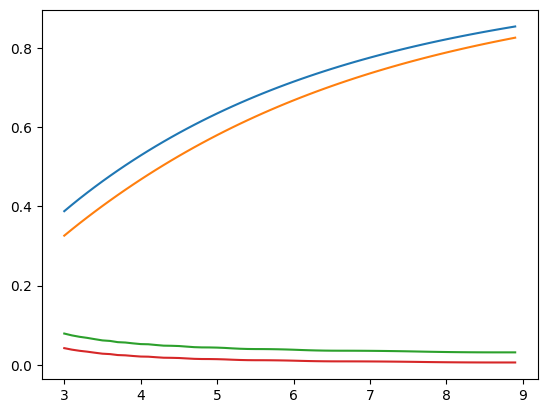

In [119]:
# KM_info2['r_info'].plot()
plt.plot(Ks_check2,F_R0u(Ks_check2))
plt.plot(Ks_check2,F_RMu(Ks_check2))
plt.plot(Ks_check2,F_R0d(Ks_check2))
plt.plot(Ks_check2,F_RMd(Ks_check2))

In [107]:
N = 2000
Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=5000,seed=seed)
KM_info2 = Qsimul.KM_space(3,5,0.2)

ValueError: x and y must have same first dimension, but have shapes (120,) and (150,)

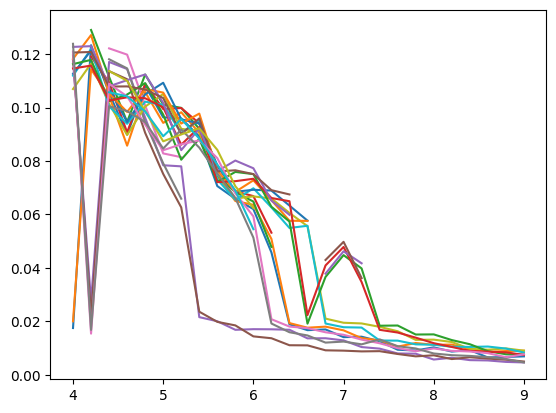

In [345]:
for seed in seeds:
    KM_info = df_s.loc[seed]['KM_info']
    plt.plot(KM_info['r_info'][['r+_total','r-_total']])
    plt.plot(KM_info['r_info'][['r+','r-']])

# plt.plot(KM_info2['r_info'][['r_mean','r+','r-']])


plt.plot(Ks_check2,rs_dFl3,color='tab:grey',alpha=0.8)
plt.plot(Ks_check2,rs_uFl3,color='tab:red',alpha=0.8)
plt.plot(Ks_check2,F_R0d(Ks_check2))


plt.plot(Ks_check2,rs_dFl2,color='tab:green',alpha=1)
plt.plot(Ks_check2,rs_uFl2,color='tab:green',alpha=1)
plt.ylim(0,0.2)

4.0         NaN
4.2    0.546985
4.4    0.592105
4.6    0.590239
4.8    0.628511
5.0    0.628315
5.2    0.647562
5.4    0.680233
5.6    0.705513
5.8    0.733029
6.0    0.751868
6.2    0.776581
6.4    0.796852
6.6    0.813093
6.8     0.82836
7.0    0.843565
7.2    0.856285
7.4     0.86749
7.6    0.883603
7.8    0.897264
8.0    0.904943
8.2    0.919595
8.4    0.931243
8.6    0.936418
8.8    0.943599
9.0    0.946302
Name: r0, dtype: object

In [33]:
Ks = KM_info['cluster_info']['max_O0'].index

In [47]:
0.3275*(np.pi)

1.0288715940506572

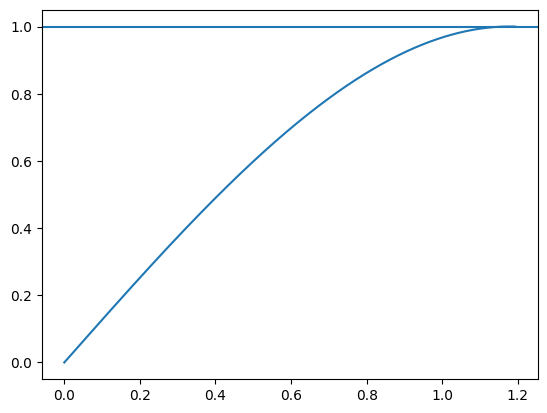

In [51]:
a = lambda x: 4/np.pi *x - 0.3056*x**3
xs = np.linspace(0,1.193,1000)
plt.plot(xs,a(xs))
plt.axhline(1)


In [54]:
RRR = F_RMu(Ks_check2)

In [92]:
Ks

Float64Index([               4.0,                4.2,                4.4,
              4.6000000000000005,  4.800000000000001,  5.000000000000001,
               5.200000000000001,  5.400000000000001,  5.600000000000001,
               5.800000000000002,  6.000000000000002,  6.200000000000002,
               6.400000000000002,  6.600000000000002, 6.8000000000000025,
               7.000000000000003,  7.200000000000003,  7.400000000000003,
               7.600000000000003,  7.800000000000003,  8.000000000000004,
               8.200000000000003,  8.400000000000004,  8.600000000000005,
               8.800000000000004,  9.000000000000004],
             dtype='float64')

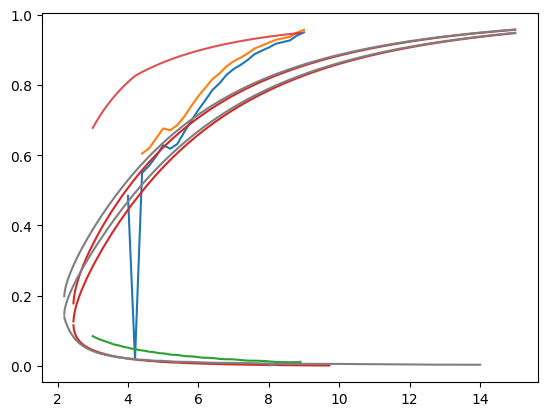

In [103]:
plt.plot(KM_info['r_info']['r_mean'])
plt.plot(KM_info['r_info']['r0'])

plt.plot(K_,F_RMd(K_),color='tab:red')
plt.plot(K_,F_RMu(K_),color='tab:red')
plt.plot(K_,F_R0u(K_),color='tab:red')

plt.plot(Ks_check2,rs_dFl3,color='tab:grey',alpha=0.8)
plt.plot(Ks_check2,2*rs_uFl3+F_R0u(Ks_check2),color='tab:red',alpha=0.8)
plt.plot(Ks_check2,F_R0d(Ks_check2))

plt.plot(K_,F_RMd2(K_),color='tab:grey')
plt.plot(K_,F_RMu2(K_),color='tab:grey')
plt.plot(K_,F_R0u2(K_),color='tab:grey')

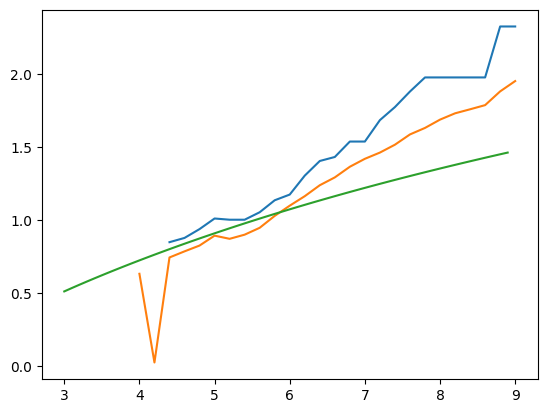

In [99]:
plt.plot(KM_info['cluster_info']['max_O0'])
plt.plot(Ks,norm.ppf(KM_info['r_info']['r_mean'].to_numpy(float)/2+0.5))
# plt.plot(Ks,4/np.pi*np.sqrt((KM_info['r_info']['r0'].to_numpy(float)*Ks/m)))

plt.plot(Ks_check2,4/np.pi*np.sqrt(RRR*Ks_check2/m)-0.3056 *np.sqrt(1/(Ks_check2*RRR*m**3)))
# plt.plot(Ks,norm.ppf(KM_info['r_info']['r0'].to_numpy(float)/2+0.5))

In [175]:
def g_n(x):
    return norm.pdf(x,0,1)
def Fab_lock1(X,m,g=g_n):
    
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(a>1.193,1,b)
    integrand_lock = lambda x:X*g_n(X*x)*np.sqrt(1-x**2)
    I_l,err = quad(integrand_lock,-b,b,limit=200)
    return I_l
def Fab_drift1(X,m,g=g_n):
    if m == 0:
        return 0
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(a>1.193,1,b)

    O_p = b*X
    # O_p = (4/np.pi)*np.sqrt(X/m)

    integrand_drift = lambda x:X*g_n(X*x)*(-a**2/(b**2+a**4))
    I_d,err = quad(integrand_drift,b,np.inf,limit=200)
    return -1*I_d

get_Fab_l1 = np.vectorize(Fab_lock1)
get_Fab_d1 = np.vectorize(Fab_drift1)



def Make_R_ab_function(m,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    RX_l1 = get_Fab_l1(X,m,g=g_n)
    RX_d1 = get_Fab_d1(X,m,g=g_n)
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    # F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    # F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    # return F_RMd,F_RMu,F_R0d,F_R0u
    return F_RMu,F_R0u

In [182]:
m

5.5

In [176]:
F_abRMu,F_abR0u =  Make_R_ab_function(m)


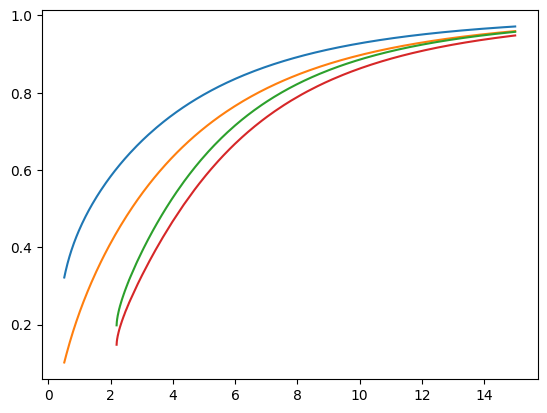

In [181]:
plt.plot(K_,F_abRMu(K_))
plt.plot(K_,F_abR0u(K_))
plt.plot(K_,F_R0u2(K_))
plt.plot(K_,F_RMu2(K_))

In [123]:
import sympy

In [132]:
x,a,b,r0,rp,K = sympy.symbols('x a b r0 rp K')
equation  = 4*(a+x)**2*x - 4*K*r0*K*rp -(K*rp)**2 - 8 *(a+x)**2*K*rp*b

sol = sympy.solve(equation,x)

In [155]:
Func_b = sol[0].simplify()

In [215]:
def Fun_theta_Omega(K,r0,rp,a,b):
    A = 1/6
    B = (-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3 + (-64*(12*K*a*b*rp - 3*a**2 + 4*(-K*b*rp + a)**2)**(3/2) + (-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3)**2))**(-1/3)
    C = -48*K*a*b*rp + 12*a**2 - 16*(K*b*rp - a)**2 + (4*K*b*rp - 4*a - (-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3 + (-64*(12*K*a*b*rp - 3*a**2 + 4*(-K*b*rp + a)**2)**(3/2) + (-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3)**2))**(1/3))*(-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3 + (-64*(12*K*a*b*rp - 3*a**2 + 4*(-K*b*rp + a)**2)**(3/2) + (-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3)**2))**(1/3)
    omega = A*B/C
    return omega

In [216]:
Fun_theta_Omega(5,0.5,0.2,1,1)

-6.331636191983082e-07

In [173]:
0.00638086441280268*10**(1/3)*(4.1214226311684 - 7.13851339664788*1j)*(-12.96 + 0.316877998339569*(-1)**(1/3)*10**(2/3)*(-2.4 - 0.316877998339569*(-1)**(1/3)*10**(2/3)))

(-1.256853700331337+1.0595257388636263j)

In [210]:
Func_b = sol[0].simplify()


In [203]:
Func_b.args

(1/6,
 (-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3 + sqrt(-64*(12*K*a*b*rp - 3*a**2 + 4*(-K*b*rp + a)**2)**3 + (-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3)**2))**(-1/3),
 -48*K*a*b*rp + 12*a**2 - 16*(K*b*rp - a)**2 + (4*K*b*rp - 4*a - (-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3 + sqrt(-64*(12*K*a*b*rp - 3*a**2 + 4*(-K*b*rp + a)**2)**3 + (-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3)**2))**(1/3))*(-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3 + sqrt(-64*(12*K*a*b*rp - 3*a**2 + 4*(-K*b*rp + a)**2)**3 + (-108*K**2*r0*rp - 27*K**2*rp**2 - 216*K*a**2*b*rp - 72*a*(-4*K*b*rp + a)*(-K*b*rp + a) + 64*(-K*b*rp + a)**3)**2))**(1/3))

In [214]:
0.0123969064830031*(-36.0 - 13.1508593303901*(-1)**(2/3))*(1.85365267699323 - 3.21062061613833*1j)

(-1.1294650664106192+0.9094360938107973j)

In [213]:
print(Func_b.subs({a:1,b:1,r0:0.5,rp:0.2,K:5}))

0.0123969064830031*(-36.0 - 13.1508593303901*(-1)**(2/3))*(1.85365267699323 - 3.21062061613833*I)


In [ ]:
plt.plot(K_,F_RMd(K_),color='tab:red')
plt.plot(K_,F_RMu(K_),color='tab:red')
plt.plot(K_,F_R0u(K_),color='tab:red')

# $ d\Omega$
db로 하는 것은 안됨, $d\Omega$로 해보자

In [358]:
def g_n(x):
    return norm.pdf(x,0,1)
def FX_lock1(X,m,g=g_n):
    # integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x))
    integrand_lock = lambda x:g(x)*np.sqrt(1-(x/X)**2)
    
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    
    A = omega_p/X
    I_l,err = quad(integrand_lock, -omega_p,omega_p,limit=200)
    return I_l/X

    # if abs(A)<=1:
    #     theta_p = np.arcsin(A)
    #     I_l,err = quad(integrand_lock,-theta_p,theta_p,limit=200)
    #     return I_l
    # else: 
    #     theta_p = np.arcsin(A)
    #     I_l,err = quad(integrand_lock,-np.pi/2,np.pi/2,limit=200)
    #     return I_l

def FX_drift1(X,m,g=g_n):
    if m == 0:
        return 0
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)


    O_p = b*X
    # O_p = (4/np.pi)*np.sqrt(X/m)

    integrand_drift = lambda x:1/(m*x**2+1/m)*g(x)
    I_d,err = quad(integrand_drift,O_p,np.inf,limit=200)
    return -1*I_d

def FX_0(X,m,O_0,g=g_n):
        O_d = min(O_0,X)
        theta_0 = np.arcsin(O_d/X)
        integrand_l = lambda x:np.cos(x)**2*g(X*np.sin(x))
        integrand_d = lambda x:(1/x**2)*g(x)
        I_l,err_l = quad(integrand_l,-theta_0,theta_0,limit=200) #lock
        I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift
        Fl = 1*I_l
        Fd = - 1/(m)*I_d
        F0 = Fl + Fd
        return F0,Fl,Fd
get_FX_l1 = np.vectorize(FX_lock1)
get_FX_d1 = np.vectorize(FX_drift1)
get_FX_0 = np.vectorize(FX_0)


def g_sec(x,Or,Om):
    g = norm.pdf(x,-Or,1)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

def get_O_r(r):
    r_s = np.linspace(r/2+0.5,1,5000,endpoint=False)
    A = norm.ppf(r_s)
    return np.mean(A)

def F_lock2_(r,K,m,F_R0, g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)

    r_0 = F_R0(K)
    O_pm = 4/np.pi*np.sqrt(K*F_R0(K)/m) - 0.3056/np.sqrt(K*F_R0(K)*m**3)
    O_r = get_O_r(r_0)
    shift_O = -(K**2*r*r_0)/(2*(O_pm)**2)/m -(K**2*r*r)/(8*(O_pm)**2)/m 
    O_pm_shift = O_pm -shift_O
    shift = -(K**2*r*r_0)/(2*(O_pm_shift)**2)/m -(K**2*r*r)/(8*(O_pm_shift)**2)/m 
    integrand_lock = lambda x:g(x+shift_O,O_r,O_pm)*np.sqrt(1-((x)/X)**2)
    omega_p = bs*X
    O_min = O_r + shift_O - omega_p
    if O_min<O_pm:
        m_ = O_min - O_pm
    else:
        m_ = np.nan
        

    I_l,err = quad(integrand_lock, -omega_p,+omega_p,limit=200)
    return I_l/X,m_
def F_drift2_(r,K,m,F_R0,g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)


    r_0 = F_R0(K)
    O_pm = 4/np.pi*np.sqrt(K*F_R0(K)/m) - 0.3056/np.sqrt(K*F_R0(K)*m**3)
    O_r = get_O_r(r_0)
    O_p = bs*X
    shift_O = -(K**2*r*r_0)/(2*(O_pm)**2)/m -(K**2*r*r)/(8*(O_pm)**2)/m 
    O_pm_shift = O_pm -shift_O
    shift = -(K**2*r*r_0)/(2*(O_pm_shift)**2)/m -(K**2*r*r)/(8*(O_pm_shift)**2)/m 
    # integrand_drift = lambda x:1/(2*(m*(x+shift_O)**2+1/m))*g(x,O_r,O_pm)
    integrand_drift = lambda x:1/(2*(m*(x)**2+1/m))*g(x+shift_O,O_r,O_pm)
    # integrand_drift = lambda x:1/(2*x**2)*g(x+shift_O,O_r,O_pm)
    I_d,err = quad(integrand_drift,+O_p,np.inf,limit=200)
    # I_dm,err = quad(integrand_drift,-np.inf,-O_p,limit=200)
    return -1*(I_d)#+I_dm)
def F_sec_(r,K,m,F_R0,g=g_sec):
    F_l2,m_ = F_lock2_(r,K,m,F_R0, g)
    F_d2 = F_drift2_(r,K,m,F_R0, g)
    return F_l2+F_d2,m_

get_Fp_l_ = np.vectorize(F_lock2_)
get_Fp_d_ = np.vectorize(F_drift2_)
get_F2_ = np.vectorize(F_sec_)


def Make_R_function(m,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    RX_l1 = X*get_FX_l1(X,m,g=g_n)
    RX_d1 = X*get_FX_d1(X,m,g=g_n)
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)
    return F_RMd,F_RMu,F_R0d,F_R0u

def Make_R0_function(m,O_0,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    F0,Fl,Fd = get_FX_0(X,m,O_0,g=g_n)
    RX_l1 = X*Fl
    RX_d1 = X*Fd
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    if m == 0:
        F_RMd = F_RMu
        F_R0d = F_R0u
    else:
        F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
        F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)


    return F_RMd,F_RMu,F_R0d,F_R0u

def get_r_sec_(K,m,FR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    mu = np.nan
    md = np.nan
    if K == 0:
        return r_sd,r_su,r_su_d,r_su_l,md,mu
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2,m_ = get_F2_(r_test,K,m,FR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    f_su,mu = F_lock2_(r_su,K,m,F_R0=FR,g=g_sec)
    f_sd,md = F_lock2_(r_sd,K,m,F_R0=FR,g=g_sec)
    r_su_l = r_su*K*f_su
    r_sd_l = r_sd*K*f_sd
    return r_sd,r_su,r_sd_l,r_su_l,md,mu

get_r_sec_np_ = np.vectorize(get_r_sec_)

In [120]:

def F_lock2(r,K,m,F_R0, g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)

    r_0 = F_R0(K)
    O_pm = norm.ppf(r_0/2+0.5)
    O_r = get_O_r(r_0)
    shift_O =lambda x: -(K**2*r*r_0)/(2*(O_r+x)**2)/m -(K**2*r*r)/(2*(2*O_r+x)**2)/m 
    integrand_lock = lambda x:g(x+shift_O(x),O_r,O_pm)*np.sqrt(1-((x)/X)**2)
    omega_p = bs*X

    I_l,err = quad(integrand_lock, -omega_p,+omega_p,limit=200)
    return I_l/X    
def F_drift2(r,K,m,F_R0,g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)


    r_0 = F_R0(K)
    O_pm = norm.ppf(r_0/2+0.5)
    O_r = get_O_r(r_0)
    O_p = bs*X
    shift_O =lambda x: -(K**2*r*r_0)/(2*(O_r+x)**2)/m -(K**2*r*r)/(2*(2*O_r+x)**2)/m 
    integrand_drift = lambda x:1/(2*(m*(x)**2+1/m))*g(x+shift_O(x),O_r,O_pm)
    # integrand_drift = lambda x:1/(2*x**2)*g(x+shift_O,O_r,O_pm)
    I_d,err = quad(integrand_drift,+O_p,np.inf,limit=200)
    # I_dm,err = quad(integrand_drift,-np.inf,-O_p,limit=200)
    return -1*(I_d)
def F_sec(r,K,m,F_R0,g=g_sec):
    F_l2 = F_lock2(r,K,m,F_R0, g)
    F_d2 = F_drift2(r,K,m,F_R0, g)
    return F_l2+F_d2

get_Fp_l = np.vectorize(F_lock2)
get_Fp_d = np.vectorize(F_drift2)
get_F2 = np.vectorize(F_sec)


def get_r_sec2(K,m,FR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    if K == 0:
        return r_sd,r_su,r_su_d,r_su_l
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2 = get_F2(r_test,K,m,FR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    r_su_l = r_su*K*F_lock2(r_su,K,m,F_R0=FR,g=g_sec)
    r_sd_l = r_sd*K*F_lock2(r_sd,K,m,F_R0=FR,g=g_sec)
    return r_sd,r_su,r_sd_l,r_su_l

get_r_sec_np = np.vectorize(get_r_sec)

In [105]:
def g_sec(x,Or,Om):
    g = norm.pdf(x,-Or,1)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

def get_O_r(r):
    r_s = np.linspace(r/2+0.5,1,5000,endpoint=False)
    A = norm.ppf(r_s)
    return np.mean(A)

def F_lock2(r,K,m,F_R0, g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)

    r_0 = F_R0(K)
    O_pm = 4/np.pi*np.sqrt(K*F_R0(K)/m) - 0.3056/np.sqrt(K*F_R0(K)*m**3)
    O_r = get_O_r(r_0)
    shift_O = -(K**2*r*r_0)/(2*(1/m**2+(O_pm)**2))/m -(K**2*r*r)/(2*(1/m**2+(2*O_pm)**2))/m 
    O_pm_shift = O_pm -shift_O
    shift = -(K**2*r*r_0)/(2*(O_pm_shift)**2)/m -(K**2*r*r)/(8*(O_pm_shift)**2)/m 
    integrand_lock = lambda x:g(x+shift_O,O_r,O_pm)*np.sqrt(1-((x)/X)**2)
    omega_p = bs*X
    O_min = O_r + shift_O - omega_p
    if O_min<O_pm:
        m_ = O_min - O_pm
    else:
        m_ = np.nan
        

    I_l,err = quad(integrand_lock, -omega_p,+omega_p,limit=200)
    return I_l/X,m_
def F_drift2(r,K,m,F_R0,g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)


    r_0 = F_R0(K)
    O_pm = 4/np.pi*np.sqrt(K*F_R0(K)/m) - 0.3056/np.sqrt(K*F_R0(K)*m**3)
    O_r = get_O_r(r_0)
    O_p = bs*X
    shift_O = -(K**2*r*r_0)/(2*(1/m**2+(O_pm)**2))/m -(K**2*r*r)/(2*(1/m**2+(2*O_pm)**2))/m 
    O_pm_shift = O_pm -shift_O
    shift = -(K**2*r*r_0)/(2*(O_pm_shift)**2)/m -(K**2*r*r)/(8*(O_pm_shift)**2)/m 
    # integrand_drift = lambda x:1/(2*(m*(x+shift_O)**2+1/m))*g(x,O_r,O_pm)
    integrand_drift = lambda x:1/(2*(m*(x)**2+1/m))*g(x+shift_O,O_r,O_pm)
    # integrand_drift = lambda x:1/(2*x**2)*g(x+shift_O,O_r,O_pm)
    I_d,err = quad(integrand_drift,+O_p,np.inf,limit=200)
    I_dm,err = quad(integrand_drift,-np.inf,-O_p,limit=200)
    return -1*(I_d+I_dm)
def F_sec(r,K,m,F_R0,g=g_sec):
    F_l2,m_ = F_lock2(r,K,m,F_R0, g)
    F_d2 = F_drift2(r,K,m,F_R0, g)
    return F_l2+F_d2,m_

get_Fp_l = np.vectorize(F_lock2)
get_Fp_d = np.vectorize(F_drift2)
get_F2 = np.vectorize(F_sec)

def get_r_sec(K,m,FR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    mu = np.nan
    md = np.nan
    if K == 0:
        return r_sd,r_su,r_su_d,r_su_l,md,mu
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2,m_ = get_F2(r_test,K,m,FR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    f_su,mu = F_lock2(r_su,K,m,F_R0=FR,g=g_sec)
    f_sd,md = F_lock2(r_sd,K,m,F_R0=FR,g=g_sec)
    r_su_l = r_su*K*f_su
    r_sd_l = r_sd*K*f_sd
    return r_sd,r_su,r_sd_l,r_su_l,md,mu

get_r_sec_np = np.vectorize(get_r_sec)

In [3]:
import TO_sim.analytical.order_sec_parameter as OSP

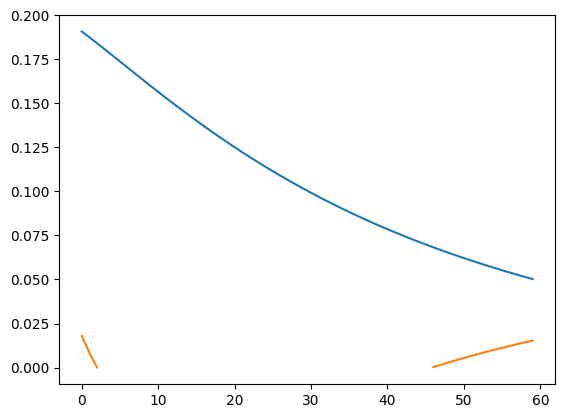

In [354]:

plt.plot(rs_uFl2)
plt.plot(rs_dFl2)

In [244]:
m 

5.5

In [30]:
m = 5
F_RMd4,F_RMu4,F_R0d4,F_R0u4 =  Make_R_function(m)


In [106]:
Ks_check2 = np.arange(0,15,0.4)
rs_d_NEW,rs_u_NEW,rs_dFl_NEW,rs_uFl_NEW,md,mu = get_r_sec_np(Ks_check2,m,F_R0u4,samples=50)

In [107]:
mu

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       -0.00750616, -0.01848823, -0.02418284, -0.02584783, -0.02429218,
       -0.01981822, -0.01293692,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan])

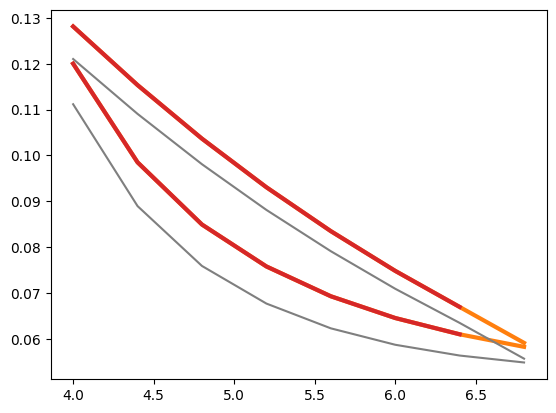

In [108]:

plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3)
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3)



plt.plot(Ks_check2[~np.isnan(mu)],rs_dFl_NEW[~np.isnan(mu)],color='tab:red',lw=3)
plt.plot(Ks_check2[~np.isnan(mu)],rs_uFl_NEW[~np.isnan(mu)],color='tab:red',lw=3)

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')

In [6]:
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import numpy as np
import TO_sim.Q_simul as QSIM
from tqdm.notebook import tqdm

In [10]:
QSIM.Q_Norm_simul(N,K=K,m = m,t_end=5000,seed=seed,start_p=True)

NameError: name 'm' is not defined

In [39]:
N = 1000
K = 4.1
seeds = np.arange(0,5)
df_s = pd.DataFrame(columns=['KM_info'],index=seeds)
for seed in tqdm(seeds):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=2000,seed=seed,start_p=True)
    KM_info = Qsimul.KM_space(2,12,0.2)
    df_s.loc[seed]['KM_info'] = KM_info

  0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
m

5

In [222]:
K_ = np.linspace(0,15,10000)

In [23]:
df_s.loc[3]['KM_info']

nan

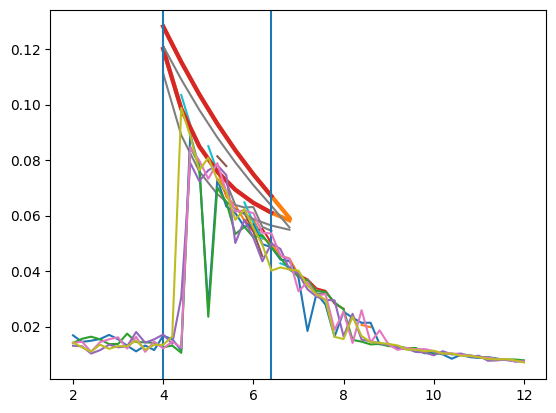

In [109]:
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')
# plt.plot(K_,F_RMu4(K_),color='tab:grey')



plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3)
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3)



plt.plot(Ks_check2[~np.isnan(mu)],rs_dFl_NEW[~np.isnan(mu)],color='tab:red',lw=3)
plt.plot(Ks_check2[~np.isnan(mu)],rs_uFl_NEW[~np.isnan(mu)],color='tab:red',lw=3)

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')

plt.axvline(Ks_check2[~np.isnan(mu)][0])
plt.axvline(Ks_check2[~np.isnan(mu)][-1])

for seed in seeds[:]:
    KM_info = df_s.loc[seed]['KM_info']
    plt.plot(KM_info['r_info'][['r+_total']])
    plt.plot(KM_info['r_info'][['r+']],zorder=0)

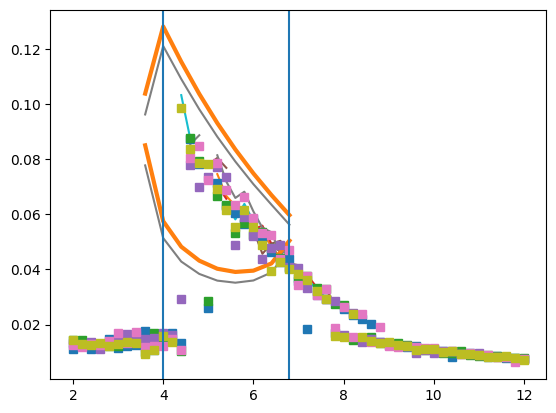

In [104]:
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')
# plt.plot(K_,F_RMu4(K_),color='tab:grey')



plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3)
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3)

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')


for seed in seeds:
    KM_info = df_s.loc[seed]['KM_info']
    plt.plot(KM_info['r_info'][['r-_total']],'s')
    plt.plot(KM_info['r_info'][['r-']],zorder=0)

plt.axvline(Ks_check2[~np.isnan(mu)][0])
plt.axvline(Ks_check2[~np.isnan(mu)][-1])

In [26]:
K_ = np.linspace(0,15,10000)

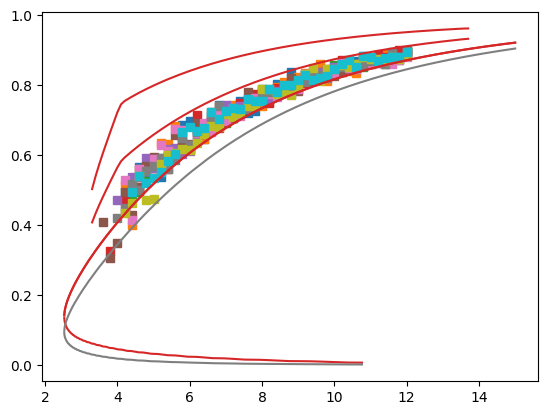

In [27]:

plt.plot(K_,F_R0d4(K_),color='tab:red')
plt.plot(K_,F_R0u4(K_),color='tab:red')
plt.plot(K_,F_RMd4(K_),color='tab:grey')
plt.plot(K_,F_RMu4(K_),color='tab:grey')


plt.plot(Ks_check2,2*rs_uFl_NEW+F_R0u4(Ks_check2),color='tab:red')
plt.plot(Ks_check2,rs_uFl_NEW+F_R0u4(Ks_check2),color='tab:red')
plt.plot(K_,F_R0u4(K_),color='tab:red')

for seed in seeds:
    KM_info = df_s.loc[seed]['KM_info']
    # plt.plot(KM_info['r_info'][['r+_total','r-_total']])
    plt.plot(KM_info['r_info'][['r0']],'s',zorder=0)

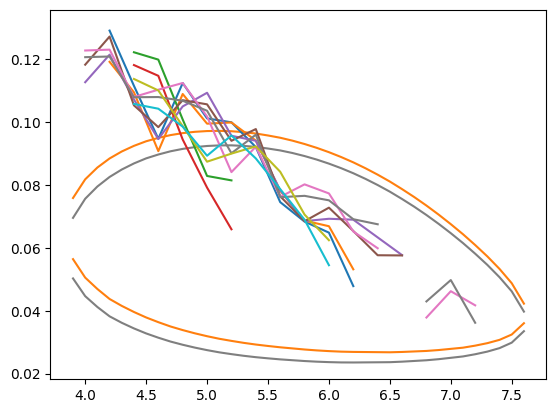

In [365]:
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')
# plt.plot(K_,F_RMu4(K_),color='tab:grey')



plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange')
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange')

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')


for seed in seeds:
    KM_info = df_s.loc[seed]['KM_info']
    # plt.plot(KM_info['r_info'][['r+_total','r-_total']])
    plt.plot(KM_info['r_info'][['r+','r-']])

In [325]:
r_test[np.isnan(F2)]

array([0.02060574])

In [326]:
get_F2(0.02060574,5.9,m,F_R0u4)

array(nan)

In [328]:
F_R0u4(5.9)

array(0.66358297)

In [331]:
F_lock2(0.02060574,5.9,m,F_R0u4, g_sec)
# F_drift2(r,K,m,F_R0u4, g_sec)

nan

In [341]:
X = 0.02060574*5.9
a = 1/np.sqrt(X*m)
b = 4/np.pi * a - 0.3056*a**3
bs = np.where(np.where(a>1.193,1,b)>1,1,b)
bs
# r_0 = F_R04(K)
# O_pm = norm.ppf(r_0/2+0.5)
# O_r = get_O_r(r_0)
# shift_O = -(K**2*r*r_0)/(2*(O_pm)**2)/m -(K**2*r*r)/(8*(O_pm)**2)/m 
# integrand_lock = lambda x:g(x+shift_O,O_r,O_pm)*np.sqrt(1-((x)/X)**2)
# omega_p = bs*X

# I_l,err = quad(integrand_lock, -omega_p,+omega_p,limit=200)

array(1.00025219)

In [25]:
K = 6

In [377]:
N

500

In [233]:
m = 7
F_RMd4,F_RMu4,F_R0d4,F_R0u4 =  Make_R_function(m)

In [232]:
m

7

In [555]:
K = 8
Qsimul = QSIM.Q_Norm_simul(2000,K=K,m = m,t_end=3000,seed=8,dt=0.1)
sol = Qsimul.solve()
cluster_info = Qsimul.get_cluster()
r_clu_info = Qsimul.get_r_clu()

In [556]:
r_clu_info['r_clu']['0'][-1]

0.829583967467824

In [557]:
r_0 = r_clu_info['r_clu']['0'][-1]
r_p = r_clu_info['r_clu_mean_last']['+']

KeyError: '+'

In [558]:
r_m0 = r_clu_info['r_total_mean'][-1]

In [559]:
omega = Qsimul.omega


In [560]:
max(omega[cluster_info['c_cluster']['0']])

1.514358130309481

In [561]:
F_R0u4(K),r_0

(array(0.73393968), 0.829583967467824)

In [562]:
O_pm = norm.ppf(r_0/2+0.5)

In [563]:
4/np.pi*np.sqrt(K*F_R0u4(K)/m) - 0.3056/np.sqrt(K*F_R0u4(K)*m**3) , O_pm, norm.ppf(F_R0u4(K)/2+0.5)

(1.1592915380576778, 1.3708682432242403, 1.1121810242957015)

In [564]:
r_p = r2t_u

In [565]:
r_0

0.829583967467824

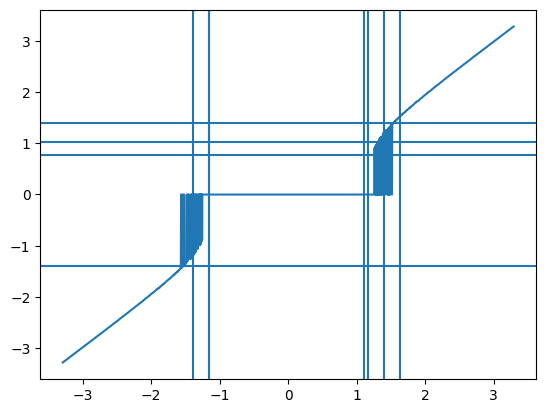

In [568]:
plt.plot(omega,cluster_info['avg_dtheta_last'])
O_pmr = norm.ppf(F_R0u4(K)/2+0.5)
O_pm = 4/np.pi*np.sqrt(K*F_R0u4(K)/m) - 0.3056/np.sqrt(K*F_R0u4(K)*m**3)
shift_O = -(K**2*r_p*r_0)/(2*(O_pm)**2)/m -(K**2*r_p*r_p)/(8*(O_pm)**2)/m 

O_pm_shift = O_pm -shift_O


shift = -(K**2*r_p*r_0)/(2*(O_pm_shift)**2)/m -(K**2*r_p*r_p)/(8*(O_pm_shift)**2)/m 
# plt.axhline(O_pm)

plt.axvline(-(4/np.pi*np.sqrt(K*F_R0u4(K)/m) - 0.3056/np.sqrt(K*F_R0u4(K)*m**3)) )
plt.axvline(O_pmr)
plt.axvline(O_pm)
plt.axvline(-O_pm)

# plt.axhline(-(O_pm-shift))
plt.axhline(O_pm-O_p)
plt.axhline(O_pm-shift_O)
plt.axvline(O_pm-2*shift_O)
plt.axhline(-(O_pm-shift_O))

plt.axhline(1.018309774929236)


plt.axvline(-(O_pm-shift_O))
plt.axvline((O_pm-shift_O))

In [528]:
r2_d,r2_u,r2t_d,r2t_u= get_r_sec_np(K,m,F_R0u4,samples=50)

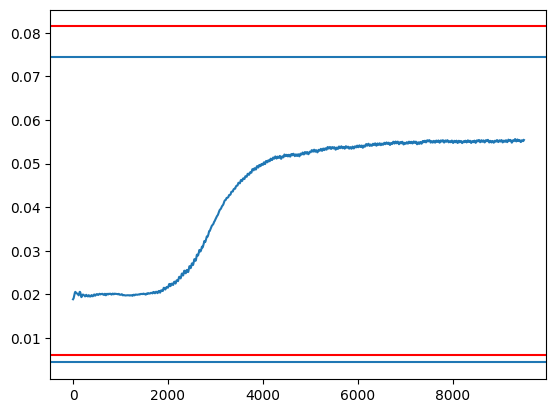

In [464]:
plt.plot(r_clu_info['r_clu_mean']['+_total'])
plt.axhline(r2_d)
plt.axhline(r2_u)
plt.axhline(r2t_d,color='red')
plt.axhline(r2t_u,color='red')

In [247]:
F_RMd4,F_RMu4,F_R0d4,F_R0u4 =  Make_R_function(m)

In [541]:
dtheta = Qsimul.dtheta

In [542]:
sum_time = 100
dtheta_c = np.cumsum(dtheta, axis=0)
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

In [543]:
O_pm = 4/np.pi*np.sqrt(K*F_R0u4(K)/m) - 0.3056/np.sqrt(K*F_R0u4(K)*m**3)
O_pm2 = norm.ppf(F_R0u4(K)/2+0.5)


In [544]:
shift_O

-0.21207520560279156

ValueError: x and y must have same first dimension, but have shapes (20000,) and (6000,)

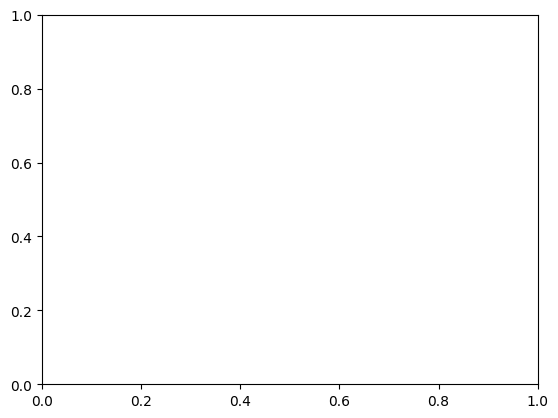

In [540]:
plt.plot(omega,avg_dtheta[19],'.')
plt.axvline(O_pm)
plt.axvline(-O_pm)


plt.plot(omega,avg_dtheta[79],'.')
plt.axvline(-(O_pm-shift_O))
plt.axvline((O_pm-shift_O))


plt.plot(omega,avg_dtheta[800],'.')
plt.axvline(-(O_pm-2*shift_O))
plt.axvline((O_pm-2*shift_O))

plt.axhline(O_pm+O_r)
plt.axhline(-(O_pm+O_r))


plt.plot(omega,avg_dtheta[8000],'.')
# plt.plot(omega,avg_dtheta[10])

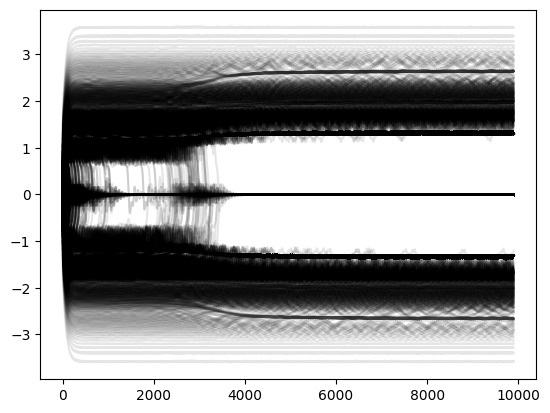

In [471]:
plt.plot(avg_dtheta,color='black',alpha=0.1);
# plt.axvline(100)


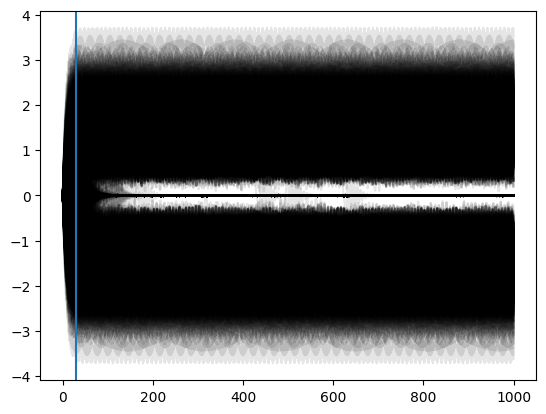

In [421]:
plt.plot(dtheta[::10],color='black',alpha=0.1);
plt.axvline(29.6)

In [ ]:
plt.axhline(F_R0u4(K))


In [419]:
np.searchsorted(r_clu_info['r_clu']['0'],F_R0u4(K))

296

In [400]:
Qsimul.t.T.shape

(100001,)

In [409]:
r_0 = F_R0u4(K)

In [410]:
O_r = quad(norm.ppf,r_0/2+0.5,1)[0]/(0.5-r_0/2)

In [ ]:
F_RMd4,F_RMu4,F_R0d4,F_R0u4 =  Make_R_function(m)


In [535]:
r_p = r2t_u

In [536]:
O_p = (4/np.pi)*np.sqrt(r_p*K/m)

In [531]:
shift_O = -(K**2*r_p*F_R0u4(K))/(2*(O_pm)**2)/m -(K**2*r_p*r_p)/(8*(O_pm)**2)/m 

In [533]:
O_r + shift_O - O_p

1.018309774929236

In [447]:
O_r + shift_O -O_pm - O_p

-0.14098176312844174

In [549]:
r_clu_info

{'t': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 1.4998e+03, 1.4999e+03,
        1.5000e+03]),
 't_mean': array([  50. ,   50.1,   50.2, ..., 1499.8, 1499.9, 1500. ]),
 'clu_name': dict_keys(['0', '+', '-', '+_total', '-_total']),
 'r_clu': {'0': array([0.00776651, 0.00778425, 0.00783727, ..., 0.74562803, 0.74541935,
         0.74522025]),
  '+': array([0.0026909 , 0.00268932, 0.00268462, ..., 0.06076817, 0.06024591,
         0.05960441]),
  '-': array([0.00286981, 0.00287141, 0.00287624, ..., 0.05945764, 0.0589101 ,
         0.05824744]),
  '+_total': array([0.00270082, 0.00269922, 0.00269447, ..., 0.06076309, 0.06025256,
         0.05962184]),
  '-_total': array([0.00284598, 0.0028476 , 0.00285249, ..., 0.05940765, 0.05886214,
         0.05820441])},
 'r_clu_mean': {'0': array([0.47488516, 0.47631274, 0.47774069, ..., 0.74653128, 0.74652828,
         0.74652451]),
  '+': array([0.01983969, 0.01988304, 0.01992612, ..., 0.069298  , 0.06928373,
         0.06926761]),
  '-': array([

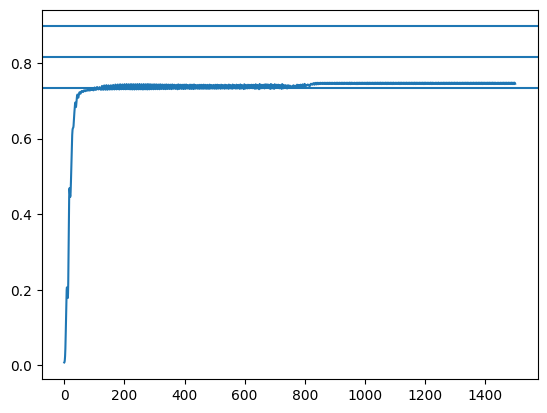

In [553]:
plt.plot(Qsimul.t,r_clu_info['r_clu']['0'])
plt.axhline(F_R0u4(K))
plt.axhline(F_R0u4(K)+r2t_u)
plt.axhline(F_R0u4(K)+2*r2t_u)
# plt.xlim(0,200)

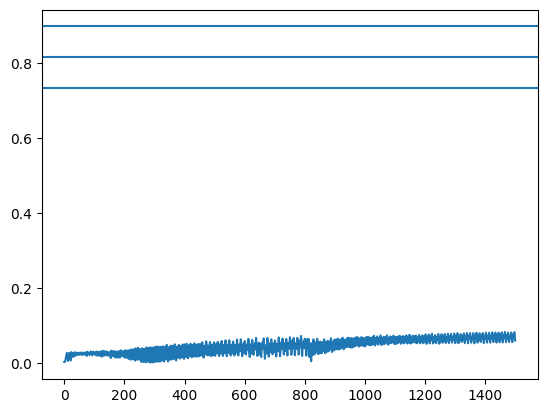

In [554]:
plt.plot(Qsimul.t,r_clu_info['r_clu']['+'])
plt.axhline(F_R0u4(K))
plt.axhline(F_R0u4(K)+r2t_u)
plt.axhline(F_R0u4(K)+2*r2t_u)
# plt.xlim(0,200)

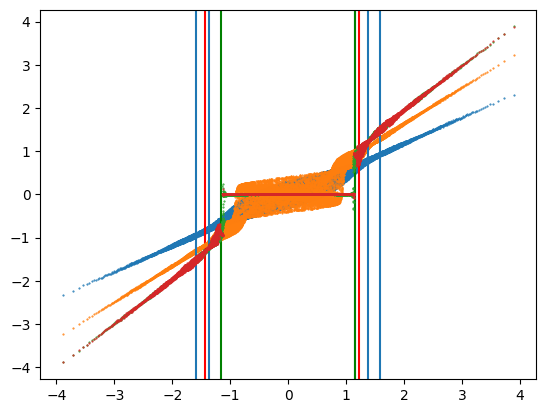

In [545]:
plt.plot(omega,avg_dtheta[19],'.',markersize=1)
plt.axvline(O_pm)
plt.axvline(O_r-O_p,color='red')
plt.axvline(-(O_r-O_p-shift_O),color='red')
plt.axvline(-O_pm,color='green')
plt.axvline(O_pm,color='green')


plt.plot(omega,avg_dtheta[79],'.',markersize=1)
plt.axvline(-(O_pm-shift_O))
plt.axvline((O_pm-shift_O))


plt.plot(omega,avg_dtheta[800],'.',markersize=1)
plt.axvline(-(O_pm-2*shift_O))
plt.axvline((O_pm-2*shift_O))



plt.plot(omega,avg_dtheta[2000],'.',markersize=1)
# plt.plot(omega,avg_dtheta[10])

## 2차 클러스터 동기화 이론 확인
클러스터의 회전 속도는 메인 클러스턷에 가까운 부분 부터 동기화 될 것이다. 따라서 2차 클러스터의 위상 속도는 메인 클러스터가 형성된 최대의 지점부터, 메인클러스터가 형성된 부분에 해당 될 것이다.

m이 작을때는 어떤 양상을 보일까?

In [7]:
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import numpy as np
import TO_sim.Q_simul as QSIM
from tqdm.notebook import tqdm

In [8]:
r_0 = F_R0u4(K)
O_pm = 4/np.pi*np.sqrt(K*F_R0u4(K)/m) - 0.3056/np.sqrt(K*F_R0u4(K)*m**3)
r = 0.2
O_r = get_O_r(r_0)
shift_O = lambda m: -(K**2*r*r_0)/(2*(1/m**2+(O_pm)**2))/m -(K**2*r*r)/(2*(1/m**2+(2*O_pm)**2))/m 
# shift_O = lambda m: -(K**2*r*r_0)/(2*((O_pm)**2))/m -(K**2*r*r)/(2*((2*O_pm)**2))/m 

NameError: name 'F_R0u4' is not defined

> shift_O의 물리적인 의미는?  
움직이는 지점을 옮기는 역활

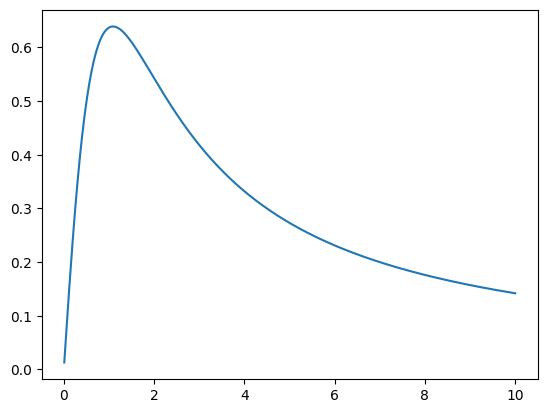

In [124]:
ms = np.linspace(0,10,1000)
plt.plot(ms,-shift_O(ms))
# plt.ylim(0,20)

In [889]:
m = 4.4
K = 5
Qsimul = QSIM.Q_Norm_simul(2000,K=K,m = m,t_end=6000,seed=1,dt=0.1,start_p=True)
sol = Qsimul.solve()
cluster_info = Qsimul.get_cluster()
r_clu_info = Qsimul.get_r_clu()

In [890]:
F_RMd,F_RMu,F_R0d,F_R0u =  Make_R_function(m)

In [891]:
dtheta = Qsimul.dtheta
sum_time = 500
dtheta_c = np.cumsum(dtheta, axis=0)
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

In [892]:
r_0 = F_R0u(K)
O_pm = 4/np.pi*np.sqrt(K*F_R0u(K)/m) - 0.3056/np.sqrt(K*F_R0u(K)*m**3)

In [893]:
P_clu = cluster_info['c_cluster']['+']
MAIN_clu = cluster_info['c_cluster']['0']

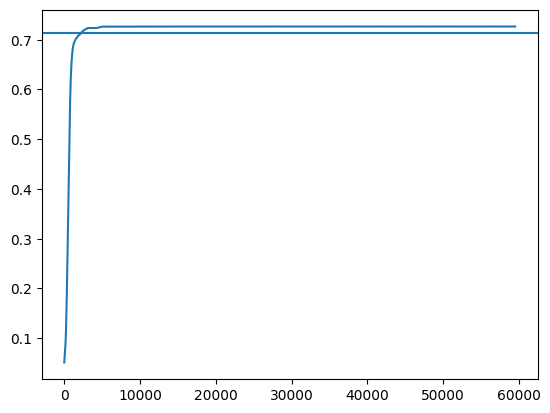

In [894]:
plt.plot(r_clu_info['r_clu_mean']['0'])
# plt.plot(r_clu_info['r_clu_mean']['+'])
# plt.plot(r_clu_info['r_clu_mean']['-'])
plt.axhline(r_0)

In [905]:
r0 = r_clu_info['r_total_mean']
r0 = r_clu_info['r_total_mean']
rP = r_clu_info['r_clu_mean']['+']

In [906]:
shift = -(K**2*rP*r0)/(2*(O_pm)**2)/m -(K**2*rP*rP)/(8*(O_pm)**2)/m

# shift = -(K**2*rP*rP)/(2*(1/m**2+(O_pm)**2))/m -(K**2*rP*rP)/(2*(1/m**2+(2*O_pm)**2))/m 
shift = -(K**2*rP*r0)/(2*(1/m**2+(O_pm)**2))/m -(K**2*rP*rP)/(2*(1/m**2+(2*O_pm)**2))/m 


In [907]:
avg_dtheta[:,P_clu].shape

(59501, 130)

In [908]:
X = K*rP
a = 1/np.sqrt(X*m)
b = 4/np.pi * a - 0.3056*a**3
bs = np.where(np.where(a>1.193,1,b)>=1,1,b)

O_p = bs*X

In [909]:
N_P = np.setdiff1d(np.arange(0,2000),[*P_clu,*MAIN_clu])

Text(0.5, 1.0, 'm=4.4,N=2000,K=5')

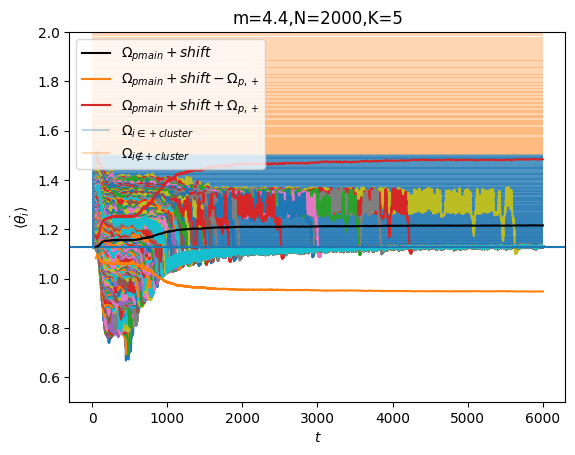

In [916]:
plt.plot(r_clu_info['t'][sum_time:],avg_dtheta[:,P_clu])
# plt.xlim(0,520)
plt.axhline(O_pm)
plt.plot(r_clu_info['t'][sum_time:],O_pm - shift,color='black',label='$\Omega_{pmain}+shift$')
plt.plot(r_clu_info['t'][sum_time:],O_pm - shift -O_p,color='tab:orange',label='$\Omega_{pmain}+shift-\Omega_{p,+}$')
plt.plot(r_clu_info['t'][sum_time:],O_pm - shift +O_p,color='tab:red',label='$\Omega_{pmain}+shift+\Omega_{p,+}$')
plt.hlines(Qsimul.omega[P_clu],0,6000,zorder=0,alpha=0.3)


plt.hlines(Qsimul.omega[P_clu],0,6000,zorder=0,alpha=0.3,label=r'$\Omega_{i\in +cluster}$')
plt.hlines(Qsimul.omega[N_P],0,6000,zorder=0,alpha=0.3,color='tab:orange',label = r'$\Omega_{i\notin +cluster}$')
plt.legend()
plt.ylim(0.5,2)
plt.ylabel(r'$\langle\dot{\theta_i}\rangle$')
plt.xlabel('$t$')
plt.title(rf'm={m},N={N},K={K}')
plt.show()

$\notin$

In [901]:
X = K*r0
a = 1/np.sqrt(X*m)
b = 4/np.pi * a - 0.3056*a**3
bs = np.where(np.where(a>1.193,1,b)>=1,1,b)

O_p = bs*X

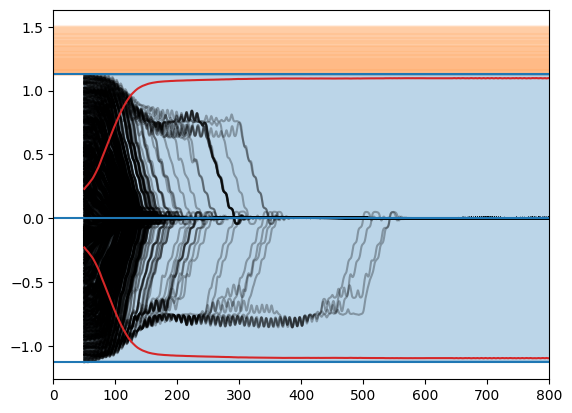

In [902]:
plt.plot(r_clu_info['t'][sum_time:],avg_dtheta[:,MAIN_clu],color='black',alpha=0.3)
plt.xlim(0,800)
plt.axhline(O_pm)
plt.axhline(-O_pm)
plt.axhline(0)

plt.fill_between(r_clu_info['t'][sum_time:],Qsimul.omega[MAIN_clu[0]],Qsimul.omega[MAIN_clu[-1]],color='tab:blue',alpha=0.3)
# plt.hlines(Qsimul.omega[MAIN_clu][],0,6000,zorder=0,alpha=0.1)
plt.hlines(Qsimul.omega[P_clu],0,6000,zorder=0,alpha=0.1,color='tab:orange')


plt.plot(r_clu_info['t'][sum_time:],-O_p,color='tab:red')
plt.plot(r_clu_info['t'][sum_time:],+O_p,color='tab:red')
plt.show()

## 새로운 알고리즘으로 $r_+$ 확인

In [360]:
def g_sec(x,Or,Om):
    g = norm.pdf(x,-Or,1)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

def get_O_r(r):
    r_s = np.linspace(r/2+0.5,1,5000,endpoint=False)
    A = norm.ppf(r_s)
    return np.mean(A)

def F_lock2(r,K,m,F_R0, g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)

    r_0 = F_R0(K)
    O_pm = 4/np.pi*np.sqrt(K*F_R0(K)/m) - 0.3056/np.sqrt(K*F_R0(K)*m**3)
    shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) -(K**2*r*r)/(2*m*(1/m**2+(O_pm)**2))
    integrand_lock = lambda x:g(x,O_pm-shift_O,O_pm)*np.sqrt(1-((x)/X)**2)
    omega_p = bs*X
    O_min = -shift_O - omega_p
    if O_min<0:
        m_ = O_min
    else:
        m_ = np.nan
        

    I_l,err = quad(integrand_lock, -omega_p,+omega_p,limit=200)
    return I_l/X,m_
def F_drift2(r,K,m,F_R0,g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)


    r_0 = F_R0(K)
    O_pm = 4/np.pi*np.sqrt(K*F_R0(K)/m) - 0.3056/np.sqrt(K*F_R0(K)*m**3)
    O_p = bs*X
    shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) -(K**2*r*r)/(2*m*(1/m**2+(O_pm)**2))

    integrand_drift = lambda x:1/(2*(m*(x+O_pm-shift_O)**2+1/m))*g(x,O_pm-shift_O,O_pm)
    # integrand_drift = lambda x:1/(2*(m*(x)**2+1/m))*g(x,O_pm-shift_O,O_pm)
    # integrand_drift = lambda x:1/(2*x**2)*g(x+shift_O,O_r,O_pm)
    I_d,err = quad(integrand_drift,+O_p,np.inf,limit=200)
    # I_dm,err = quad(integrand_drift,-np.inf,-O_p,limit=200)
    return -1*(I_d)#+I_dm)
def F_sec(r,K,m,F_R0,g=g_sec):
    F_l2,m_ = F_lock2(r,K,m,F_R0, g)
    F_d2 = F_drift2(r,K,m,F_R0, g)
    return F_l2+F_d2,m_

get_Fp_l = np.vectorize(F_lock2)
get_Fp_d = np.vectorize(F_drift2)
get_F2 = np.vectorize(F_sec)


def Make_R_function(m,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    RX_l1 = X*get_FX_l1(X,m,g=g_n)
    RX_d1 = X*get_FX_d1(X,m,g=g_n)
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    if m == 0:
        F_RMd = F_RMu
        F_R0d = F_R0u
    else:
        F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
        F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)

    return F_RMd,F_RMu,F_R0d,F_R0u

def Make_R0_function(m,O_0,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    F0,Fl,Fd = get_FX_0(X,m,O_0,g=g_n)
    RX_l1 = X*Fl
    RX_d1 = X*Fd
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)
    if m == 0:
        F_RMd = F_RMu
        F_R0d = F_R0u
    else:
        F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
        F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)

    return F_RMd,F_RMu,F_R0d,F_R0u

def get_r_sec(K,m,FR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    mu = np.nan
    md = np.nan
    if (K == 0)or (m==0):
        return r_sd,r_su,r_su_d,r_su_l,md,mu
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2,m_ = get_F2(r_test,K,m,FR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    f_su,mu = F_lock2(r_su,K,m,F_R0=FR,g=g_sec)
    f_sd,md = F_lock2(r_sd,K,m,F_R0=FR,g=g_sec)
    r_su_l = r_su*K*f_su
    r_sd_l = r_sd*K*f_sd
    return r_sd,r_su,r_sd_l,r_su_l,md,mu

get_r_sec_np = np.vectorize(get_r_sec)

$m_c = 4.015, K_c = 5$

$m_c = 3.912435, K_c = 4.363$

$m_c = 3.914, K_c = 4.03$  
새로운 알고리즘으로 확인하는 것

In [459]:
m = 3.9133
F_RMd4,F_RMu4,F_R0d4,F_R0u4 =  Make_R_function(m)
r_d = lambda x: (F_R0u4(x)-F_RMu4(x))/2

# Ks_check2 = np.arange(4.36,4.38,0.001)
Ks_check2 = np.arange(4.02,4.08,0.01)
rs_d_NEW,rs_u_NEW,rs_dFl_NEW,rs_uFl_NEW,md,mu = get_r_sec_np(Ks_check2,m,F_RMu4,samples=150)

[4.03 4.04 4.08]


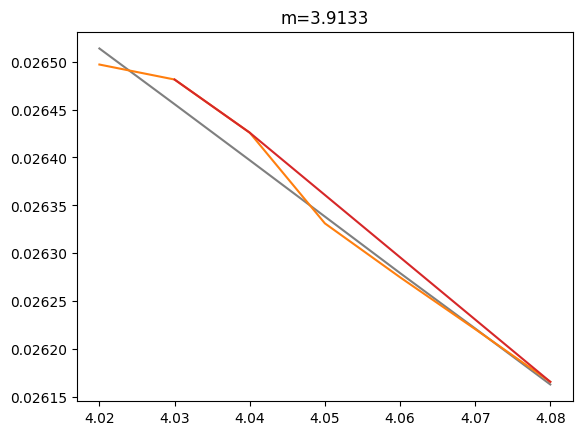

In [460]:
r_d = lambda x: (F_R0u4(x)-F_RMu4(x))/2

indexs, = np.where(r_d(Ks_check2)<=rs_uFl_NEW)
print(Ks_check2[indexs])
plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange')
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange')
plt.plot(Ks_check2[indexs],rs_dFl_NEW[indexs],color='tab:red')
plt.plot(Ks_check2[indexs],rs_uFl_NEW[indexs],color='tab:red')
plt.title(f'm={m}')
# plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey',zorder=0)
plt.plot(Ks_check2,(F_R0u4(Ks_check2)-F_RMu4(Ks_check2))/2,color='tab:grey',zorder=0)

0.021658803202193728


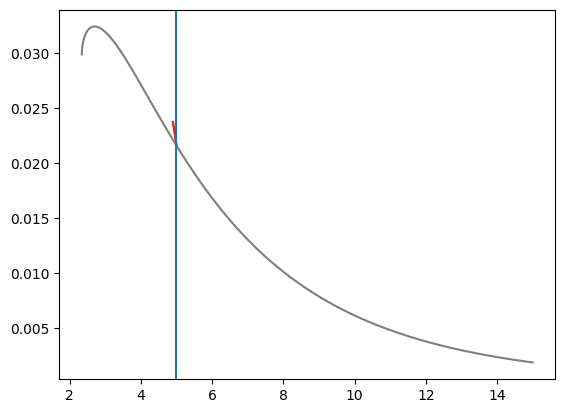

In [412]:
plt.plot(Ks_check2,rs_d_NEW,color='tab:orange')
plt.plot(Ks_check2,rs_u_NEW,color='tab:orange')

plt.plot(Ks_check2[~np.isnan(mu)],rs_d_NEW[~np.isnan(mu)],color='tab:red')
plt.plot(Ks_check2[~np.isnan(mu)],rs_u_NEW[~np.isnan(mu)],color='tab:red')

plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey')
plt.axvline(5)
if (F_R0u4(5)-F_RMu4(5))/2<rs_u_NEW[np.searchsorted(Ks_check2,4.99)]:
    print(rs_u_NEW[np.searchsorted(Ks_check2,4.99)])

In [253]:
mu

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, -0.01063615,
       -0.02539237, -0.03104001, -0.0314179 , -0.02844466, -0.02307976,
       -0.01577563, -0.00712766,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [254]:
Ks_check2[~np.isnan(mu)],rs_uFl_NEW[~np.isnan(mu)]

(array([3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2]),
 array([0.0041998 , 0.00950498, 0.01103933, 0.01064054, 0.00919311,
        0.00713231, 0.00467066, 0.00202531]))

In [128]:
rs_d,rs_u,rs_dFl,rs_uFl,md,mu = get_r_sec_np2(Ks_check2,m,F_R0u4,samples=50)


In [204]:
rs_uFl_NEW

array([           nan,            nan,            nan,            nan,
       2.63722504e-05, 2.63116565e-05, 2.62508973e-05, 2.61892168e-05,
       2.61303305e-05, 8.89926692e-05, 5.73588063e-05, 5.71797553e-05,
       5.70047843e-05, 2.58331861e-05,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan])

(0.0, 0.03407719148693955)

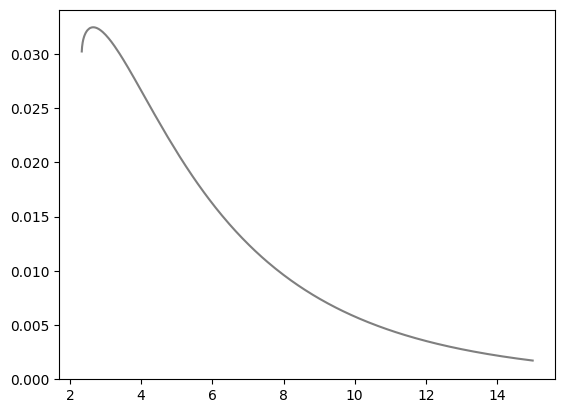

In [210]:
plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3)
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3)

plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey')


# plt.plot(Ks_check2[~np.isnan(mu)],rs_dFl_NEW[~np.isnan(mu)],color='tab:red',lw=3)
# plt.plot(Ks_check2[~np.isnan(mu)],rs_uFl_NEW[~np.isnan(mu)],color='tab:red',lw=3)

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')
plt.ylim(0)

In [150]:
mu

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan, -0.14063644, -0.15067061, -0.1538548 , -0.1542617 ,
       -0.15244961, -0.14840687, -0.141428  , -0.12579749,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan])

In [34]:
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import numpy as np
import TO_sim.Q_simul as QSIM
from tqdm.notebook import tqdm

In [116]:
N = 1000
K = 4.1
seeds = np.arange(0,10)
df_s = pd.DataFrame(columns=['KM_info'],index=seeds)
for seed in tqdm(seeds):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=2000,seed=seed,start_p=True)
    KM_info = Qsimul.KM_space(2,15,0.2)
    df_s.loc[seed]['KM_info'] = KM_info

  0%|          | 0/10 [00:00<?, ?it/s]

In [258]:
N = 1000
K = 4.1
seeds = np.arange(0,5)
df_s40 = pd.DataFrame(columns=['KM_info'],index=seeds)
for seed in tqdm(seeds):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=2000,seed=seed,start_p=False)
    KM_info = Qsimul.KM_space(3,5,0.1)
    df_s40.loc[seed]['KM_info'] = KM_info

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
N = 1000
K = 4.1
seeds = np.arange(0,5)
df_s_0 = pd.DataFrame(columns=['KM_info'],index=seeds)
for seed in tqdm(seeds):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=2000,seed=seed,start_p=False)
    KM_info = Qsimul.KM_space(2,15,0.2)
    df_s_0.loc[seed]['KM_info'] = KM_info

In [63]:
K_ = np.linspace(0,15,10000)

In [ ]:
df_s.loc[3]['KM_info']

nan

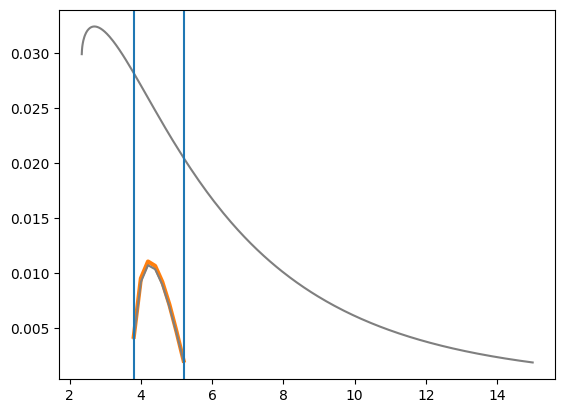

In [260]:
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')
# plt.plot(K_,F_RMu4(K_),color='tab:grey')



plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3)
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3)

plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey')


# plt.plot(Ks_check2[~np.isnan(mu)],rs_dFl_NEW[~np.isnan(mu)],color='tab:red',lw=3)
# plt.plot(Ks_check2[~np.isnan(mu)],rs_uFl_NEW[~np.isnan(mu)],color='tab:red',lw=3)

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')

plt.axvline(Ks_check2[~np.isnan(mu)][0])
plt.axvline(Ks_check2[~np.isnan(mu)][-1])

for seed in seeds[:]:
    KM_info = df_s40.loc[seed]['KM_info']
    # plt.plot(KM_info['r_info'][['r+_total']])
    plt.plot(KM_info['r_info'][['r+']],zorder=0)

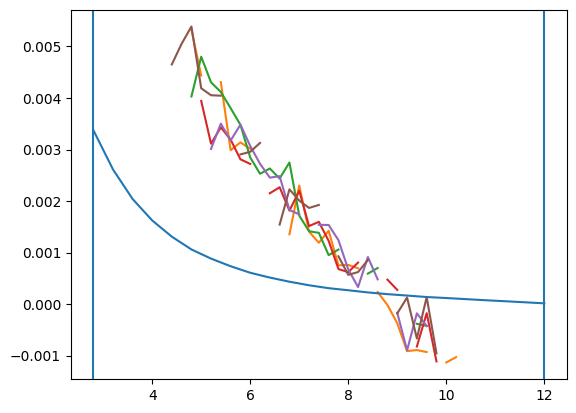

In [146]:
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')
# plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey')


# plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3,zorder=10)
# plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3,zorder=10)

# plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
# plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')

plt.plot(Ks_check2,rs_uFl_NEW-rs_u_NEW,zorder=10)


# plt.plot(Ks_check2,rs_dFl,color='tab:red',lw=3)
# plt.plot(Ks_check2,rs_uFl,color='tab:red',lw=3)

# plt.plot(Ks_check2,rs_d,color='tab:grey')
# plt.plot(Ks_check2,rs_u,color='tab:grey')


for seed in seeds:
    KM_info = df_s.loc[seed]['KM_info']
    temp = KM_info['Ks']
    # plt.plot(KM_info['r_info'][['r-_total']])
    # plt.plot(KM_info['r_info'][['r-']],'s',zorder=3)
    plt.plot(temp,KM_info['r_info'][['r-']].to_numpy(float)-KM_info['r_info'][['r-_total']].to_numpy(float))

plt.axvline(Ks_check2[~np.isnan(mu)][0])
plt.axvline(Ks_check2[~np.isnan(mu)][-1])

In [142]:
KM_info

{'Ks': array([ 2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,
         4.2,  4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,
         6.4,  6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,
         8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6,
        10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8,
        13. , 13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. ]),
 'r_info':         r_mean        r0   r+   r-  r+_total  r-_total  sig_mean      sig0  \
 2.0   0.017389       NaN  NaN  NaN  0.014469  0.014206  0.010697       NaN   
 2.2   0.015658       NaN  NaN  NaN  0.012866  0.013176  0.010348       NaN   
 2.4   0.014779       NaN  NaN  NaN  0.010746   0.01282  0.008768       NaN   
 2.6   0.016671       NaN  NaN  NaN  0.014353  0.014485  0.009666       NaN   
 2.8   0.014041       NaN  NaN  NaN  0.012076  0.011509  0.008488       NaN   
 ...        ...       ...  ...  ...       ...       ...       ..

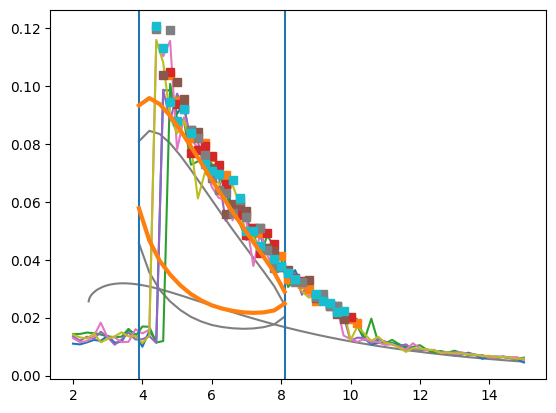

In [314]:
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')
plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey')


plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3,zorder=10)
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3,zorder=10)

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')

for seed in seeds:
    KM_info = df_s.loc[seed]['KM_info']
    plt.plot(KM_info['r_info'][['r-_total']] )
    plt.plot(KM_info['r_info'][['r-']],'s',zorder=3)

plt.axvline(Ks_check2[~np.isnan(mu)][0])
plt.axvline(Ks_check2[~np.isnan(mu)][-1])

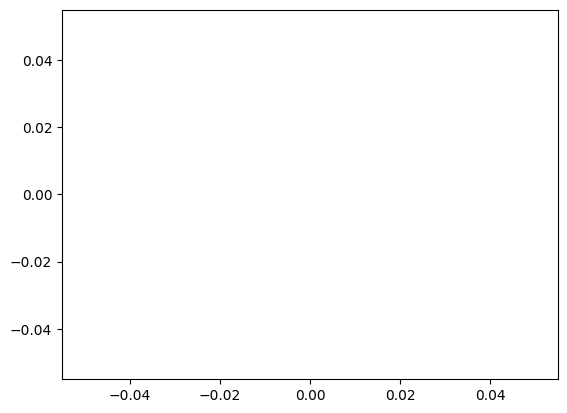

TypeError: 'float' object is not subscriptable

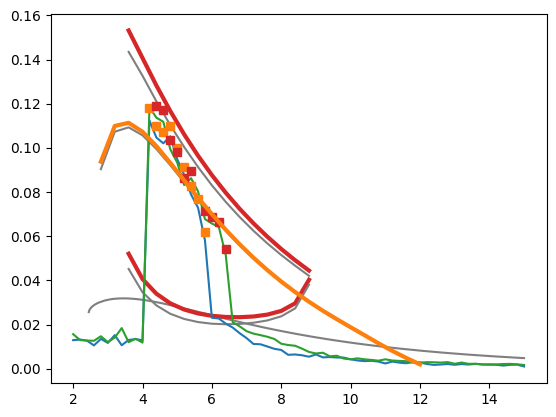

In [136]:
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')
plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey')


plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3,zorder=10)
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3,zorder=10)

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')



plt.plot(Ks_check2,rs_dFl,color='tab:red',lw=3)
plt.plot(Ks_check2,rs_uFl,color='tab:red',lw=3)

plt.plot(Ks_check2,rs_d,color='tab:grey')
plt.plot(Ks_check2,rs_u,color='tab:grey')


for seed in seeds[:3]:
    KM_info = df_s_0.loc[seed]['KM_info']
    plt.plot(KM_info['r_info'][['r-_total']])
    plt.plot(KM_info['r_info'][['r-']],'s',zorder=3)

plt.axvline(Ks_check2[~np.isnan(mu)][0])
plt.axvline(Ks_check2[~np.isnan(mu)][-1])

In [ ]:
K_ = np.linspace(0,15,10000)

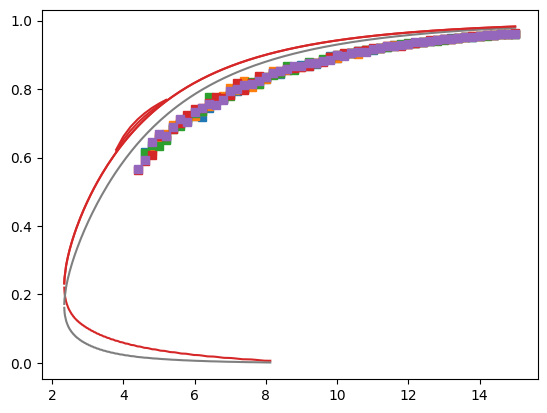

In [261]:

plt.plot(K_,F_R0d4(K_),color='tab:red')
plt.plot(K_,F_R0u4(K_),color='tab:red')
plt.plot(K_,F_RMd4(K_),color='tab:grey')
plt.plot(K_,F_RMu4(K_),color='tab:grey')


plt.plot(Ks_check2,2*rs_uFl_NEW+F_R0u4(Ks_check2),color='tab:red')
plt.plot(Ks_check2,rs_uFl_NEW+F_R0u4(Ks_check2),color='tab:red')
plt.plot(K_,F_R0u4(K_),color='tab:red')

for seed in seeds:
    KM_info = df_s.loc[seed]['KM_info']
    # plt.plot(KM_info['r_info'][['r+_total','r-_total']])
    plt.plot(KM_info['r_info'][['r0']],'s',zorder=0)

동기화가 일어나는 조건은 maincluster가 형성되면서 돌아다니는 텀의 영향인 drift보다 클때 나타난다고 가정.
위에서 확인한 이론 자체는 잘 맞는다는 것을 확인

In [346]:
m = 4.3 # 5.5
F_RMd4,F_RMu4,F_R0d4,F_R0u4 =  Make_R_function(m)

# Ks_check2 = np.arange(4.36,4.38,0.001)
Ks_check2 = np.arange(0,8,0.2)
rs_d_NEW,rs_u_NEW,rs_dFl_NEW,rs_uFl_NEW,md,mu = get_r_sec_np(Ks_check2,m,F_RMu4,samples=50)

Text(0, 0.5, '$y_+$')

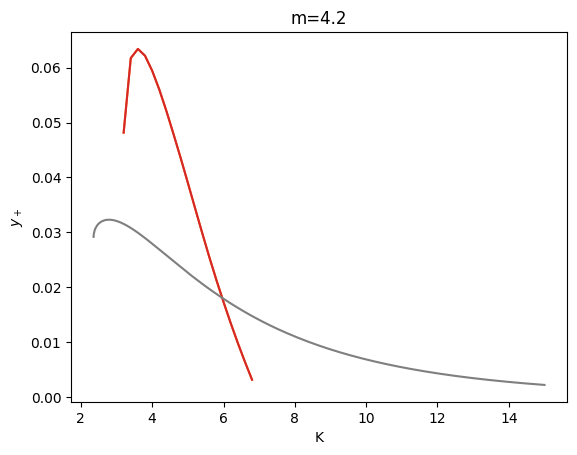

In [825]:
plt.plot(Ks_check2,rs_d_NEW,color='tab:orange')
plt.plot(Ks_check2,rs_u_NEW,color='tab:orange')

plt.plot(Ks_check2[~np.isnan(mu)],rs_d_NEW[~np.isnan(mu)],color='tab:red')
plt.plot(Ks_check2[~np.isnan(mu)],rs_u_NEW[~np.isnan(mu)],color='tab:red')


plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey')
plt.title(f'm={m}')
plt.xlabel(f'K')
plt.ylabel(f'$y_+$')

In [291]:
N = 1000
K = 4.1
seeds = np.arange(0,5)
df_s43 = pd.DataFrame(columns=['KM_info'],index=seeds)
for seed in tqdm(seeds):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=3000,seed=seed,start_p=True)
    KM_info = Qsimul.KM_space(3,7,0.1)
    df_s43.loc[seed]['KM_info'] = KM_info
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')


  0%|          | 0/5 [00:00<?, ?it/s]

In [344]:
seeds = np.arange(0,5)


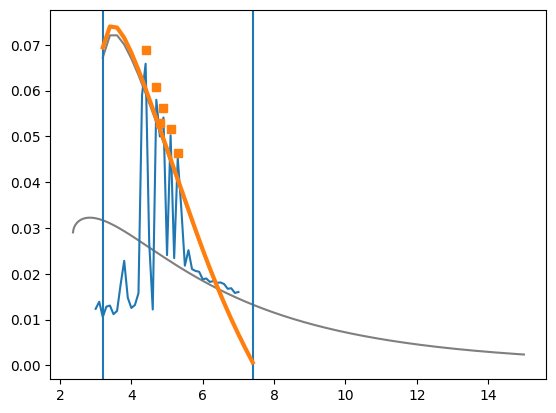

In [349]:
plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey')


plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3,zorder=10)
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3,zorder=10)

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')

for seed in seeds[3:4]:
    KM_info = df_s43.loc[seed]['KM_info']
    plt.plot(KM_info['r_info'][['r-_total']] )
    plt.plot(KM_info['r_info'][['r-']],'s',zorder=3)
    # plt.plot(KM_info['r_info'][['sig_mean']],'x',zorder=3)

plt.axvline(Ks_check2[~np.isnan(mu)][0])
plt.axvline(Ks_check2[~np.isnan(mu)][-1])

In [821]:
m = 4.2 # 5.5
F_RMd4,F_RMu4,F_R0d4,F_R0u4 =  Make_R_function(m)

# Ks_check2 = np.arange(4.36,4.38,0.001)
Ks_check2 = np.arange(0,10,0.2)
rs_d_NEW,rs_u_NEW,rs_dFl_NEW,rs_uFl_NEW,md,mu = get_r_sec_np(Ks_check2,m,F_RMu4,samples=50)

In [822]:
Ks_check2[~np.isnan(rs_uFl_NEW)],Ks_check2[~np.isnan(mu)],

(array([3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6,
        5.8, 6. , 6.2, 6.4, 6.6, 6.8]),
 array([3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6,
        5.8, 6. , 6.2, 6.4, 6.6, 6.8]))

Text(0, 0.5, '$y_+$')

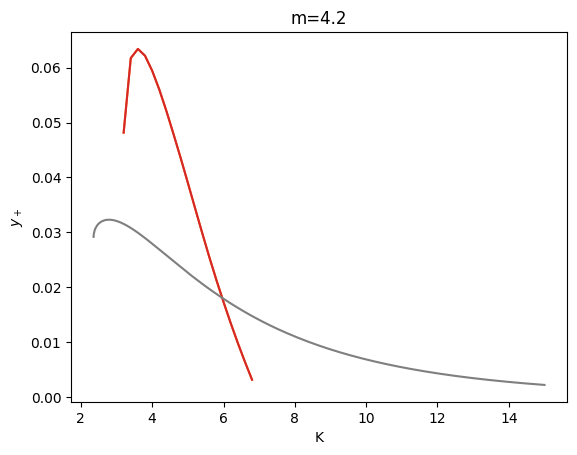

In [823]:
plt.plot(Ks_check2,rs_d_NEW,color='tab:orange')
plt.plot(Ks_check2,rs_u_NEW,color='tab:orange')

plt.plot(Ks_check2[~np.isnan(mu)],rs_d_NEW[~np.isnan(mu)],color='tab:red')
plt.plot(Ks_check2[~np.isnan(mu)],rs_u_NEW[~np.isnan(mu)],color='tab:red')


plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey')
plt.title(f'm={m}')
plt.xlabel(f'K')
plt.ylabel(f'$r_+$')

In [828]:
N = 2000
K = 4.1
seeds = np.arange(0,20)
df_s42 = pd.DataFrame(columns=['KM_info'],index=seeds)
for seed in tqdm(seeds):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=2000,seed=seed,start_p=True)
    KM_info = Qsimul.KM_space(3,7,0.1)
    df_s42.loc[seed]['KM_info'] = KM_info

  0%|          | 0/20 [00:00<?, ?it/s]

In [932]:
m = 4.2

Text(0, 0.5, '$r_+$')

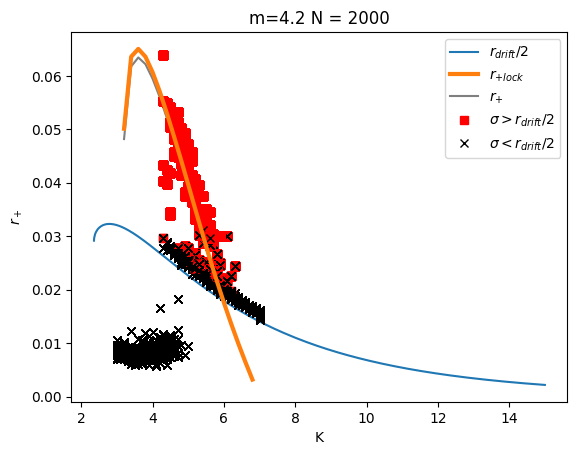

In [936]:
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')
plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:blue',label='$r_{drift}/2$')


plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3,zorder=10)
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3,zorder=10,label='$r_{+lock}$')

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey',label='$r_{+}$')

for seed in seeds:
    KM_info = df_s42.loc[seed]['KM_info']
    Ks_ = KM_info['Ks']
    rmm = KM_info['r_info'][['r-_total']].to_numpy(float)
    sig = KM_info['r_info'][['sig_mean']].to_numpy(float)
    rm = np.where(sig>(F_R0u4(Ks_)-F_RMu4(Ks_))/2,rmm,np.nan)
    rnot_m = np.where(sig>(F_R0u4(Ks_)-F_RMu4(Ks_))/2,np.nan,rmm)

    plt.plot(Ks_,rm,'s',color='red')
    plt.plot(Ks_,rnot_m,'x',color='black')
    # plt.plot()
    # plt.plot(KM_info['r_info'][['r-_total']],'o' )
    # # plt.plot(KM_info['r_info'][['r0']] )
    # # plt.plot(KM_info['r_info'][['r-']],'s',zorder=3)
    # plt.plot(KM_info['r_info'][['sig_mean']],'x',zorder=3)
plt.plot(np.nan,np.nan,'rs',label='$\sigma>r_{drift}/2$')
plt.plot(np.nan,np.nan,'kx',label='$\sigma<r_{drift}/2$')
plt.legend()
# plt.axvline(Ks_check2[~np.isnan(mu)][0])
# plt.axvline(Ks_check2[~np.isnan(mu)][-1])

plt.title(f'm={m} N = {N}')
plt.xlabel(f'K')
plt.ylabel(f'$r_+$')

## 새로운 알고리즘으로 시뮬레이션

In [7]:
import warnings
from tqdm.notebook import tqdm
import TO_sim.analytical.sec_order_parameter2 as OSP2
import numpy as np
import pandas as pd
warnings.filterwarnings(action='ignore')

import TO_sim.Q_simul as QSIM
from tqdm.notebook import tqdm

In [8]:
df = pd.DataFrame(columns=['K','m','rM_u','rM_d',
                           'r0_u','r0_d','rd_u','rd_d',
                           'r+_ul','r+_drift','mu',
                           'r+_total_u','r+_total_d','r+_total_ul','r+_total_ud'])
df = df.set_index(['K','m'])

In [9]:
Ks = np.arange(0.0,15+0.05,0.1)
ms = np.arange(0.0,15+0.05,0.1)

In [4]:
core = 31
index_ = 0
m_set = [] 
for i in range(len(ms)//core +1):
    m_set.append(ms[index_:index_+core])
    index_ += core
num = 0

In [545]:
df.sort_index().to_excel(f'231108 MULTI/{num} Order parameter and secondary cluster.xlsm')

In [507]:
N = 500
K = 4.1
seeds = np.arange(1,3)
m = 6
df_s6 = pd.DataFrame(columns=['KM_info'],index=seeds)
for seed in tqdm(seeds):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=1000,seed=seed,start_p=True)
    KM_info = Qsimul.KM_space(3,12,0.2)
    df_s6.loc[seed]['KM_info'] = KM_info
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')


  0%|          | 0/2 [00:00<?, ?it/s]

In [516]:
150*3/60

7.5

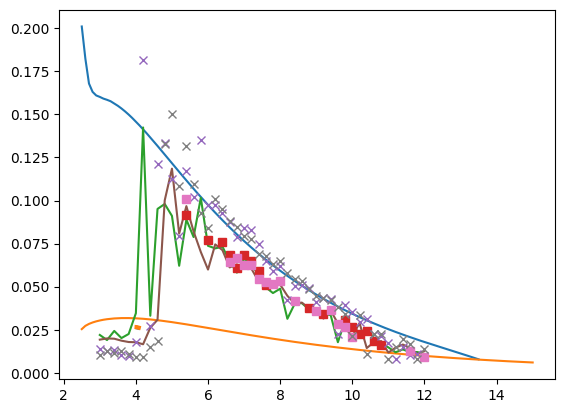

In [518]:
# plt.plot(K_,F_R0d4(K_),color='tab:red')
# plt.plot(K_,F_R0u4(K_),color='tab:red')
# plt.plot(K_,F_RMd4(K_),color='tab:grey')

# plt.plot(K_,(F_R0u4(K_)-F_RMu4(K_))/2,color='tab:grey')

plt.plot(df_6['r+_ul'])
plt.plot(df_6['r+_drift'])
# df['r+_drift'].plot()
plt.plot(Ks_check2,rs_dFl_NEW,color='tab:orange',lw=3,zorder=10)
plt.plot(Ks_check2,rs_uFl_NEW,color='tab:orange',lw=3,zorder=10)

plt.plot(Ks_check2,rs_d_NEW,color='tab:grey')
plt.plot(Ks_check2,rs_u_NEW,color='tab:grey')

for seed in seeds[:2]:
    KM_info = df_s6.loc[seed]['KM_info']
    plt.plot(KM_info['r_info'][['r-_total']] )
    # plt.plot(KM_info['r_info'][['r0']] )
    plt.plot(KM_info['r_info'][['r-']],'s',zorder=3)
    plt.plot(KM_info['r_info'][['sig_mean']],'x',zorder=3)


## K_c(N), Size dependance check

In [790]:
Ns  = [100,500,1000,2000,3000,4000,5000]
r_min4  = []
rM_min = []
rM = []
seed = np.arange(20)
for s in seed:
    K = 3
    N = 3000
    m = 6
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=3000,seed=s,dt=0.1,start_p=True)
    sol = Qsimul.solve()
    cluster_info = Qsimul.get_cluster()
    r_clu_info = Qsimul.get_r_clu()
    rM_min.append(r_clu_info['r_total_mean'].min())
    r_min4.append(sol['rs'].min())
    rM.append(r_clu_info['r_total_mean'][-1])

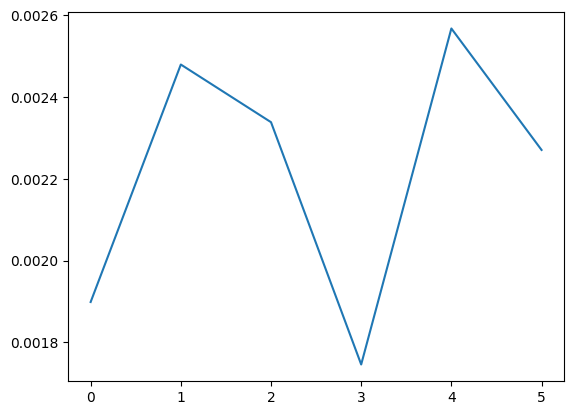

In [794]:
N_ = [0.001898884512159469, 0.0024795002482759067, 0.0023385365850196863,0.0017461675523237103,0.00256763668187617,0.002270635697129543]
plt.plot(N_)

In [793]:
np.mean(np.array(r_min4)*np.sqrt(N))

0.002270635697129543

(0.001898884512159469,
 0.0024795002482759067,
 0.0023385365850196863,
 0.0017461675523237103)

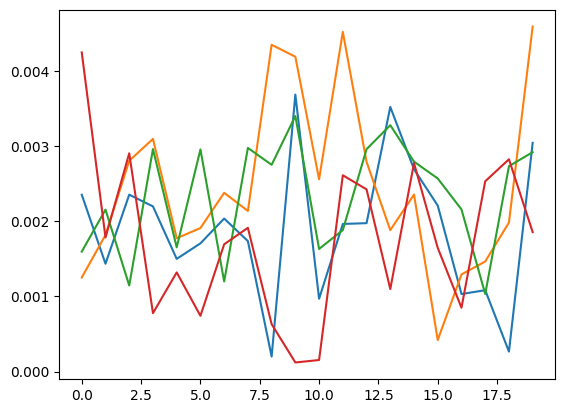

In [780]:
plt.plot(seed,np.array(r_min)*np.sqrt(500))
plt.plot(seed,np.array(r_min2)*np.sqrt(1000))
plt.plot(seed,np.array(r_min3)*np.sqrt(1500))
plt.plot(seed,np.array(r_min4)*np.sqrt(2000))
plt.plot(seed,np.array(r_min5)*np.sqrt(2500))
np.mean(np.array(r_min)*np.sqrt(500)),np.mean(np.array(r_min2)*np.sqrt(1000)),np.mean(np.array(r_min3)*np.sqrt(1500)),np.mean(np.array(r_min4)*np.sqrt(2000))
# plt.loglog()
# plt.loglog()

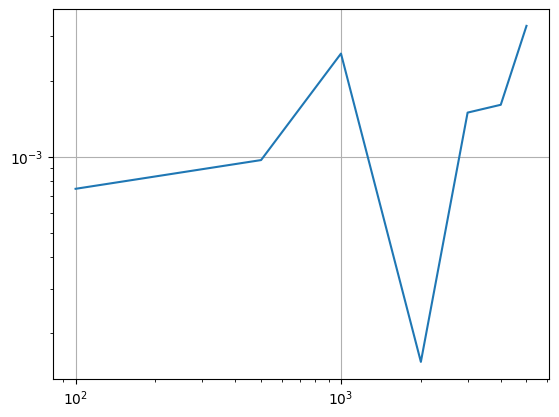

In [755]:
plt.plot(Ns, r_min*np.sqrt(Ns))
# plt.plot(Ns, rM_min*np.sqrt(Ns))

# plt.plot(Ns, rM*np.sqrt(Ns))
plt.loglog()
plt.grid()

In [734]:
r_clu_info['r_total_mean'].min()*np.sqrt(N)

0.31252192812521185

In [735]:
sol['rs'].min()

1.158694559869588e-05

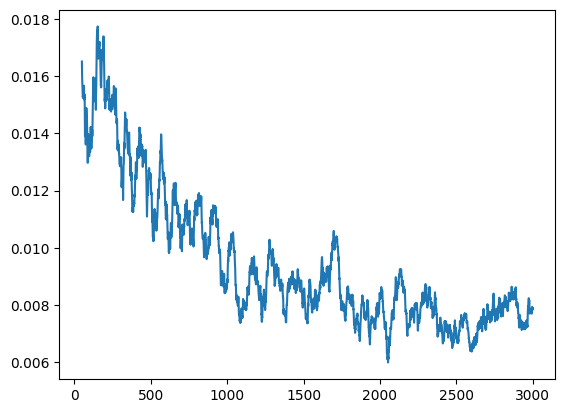

In [792]:
plt.plot(r_clu_info['t_mean'],r_clu_info['r_total_mean'])
# plt.axhline(0.5/np.sqrt(N))

In [733]:
1.158694559869588e-05*np.sqrt(N)

0.00036641139216342307

In [707]:
3.300847364224996e-05*np.sqrt(N)

0.0020876391759028765

In [555]:
omega = Qsimul.omega

In [564]:
import scipy.special as ss

In [578]:
1/np.sqrt(3*m/N**0.5)

1.576236015005293

In [575]:
A = np.mean(m/(1+m**2*omega**2)*norm.pdf(omega))
2/(np.pi*norm.pdf(0)-A)

2.3957437294515005

In [571]:
Kc = lambda m,sig=1 :np.sqrt(8/np.pi) * sig/(1-np.exp(1/(2*m**2*sig**2))*(1-ss.erf(1/(np.sqrt(2)*m*sig))))

In [805]:
Kc(4.)

9.281192028203135

In [819]:
def F_c(K,N,m,g=g_n):
    r = 3e-3/np.sqrt(N)
    X = K*r
    integrand_l = lambda x: g(x)*np.sqrt(1-x/X)
    integrand_d = lambda x:-1/(m*(x)**2+1/m)*g(x)
    Il,_ = quad(integrand_l,-X,X)/X
    Id,_ = quad(integrand_d,X,np.inf)
    return Il +Id
get_Fc = np.vectorize(F_c)

In [814]:
Ks = np.linspace(0.1,6,300)

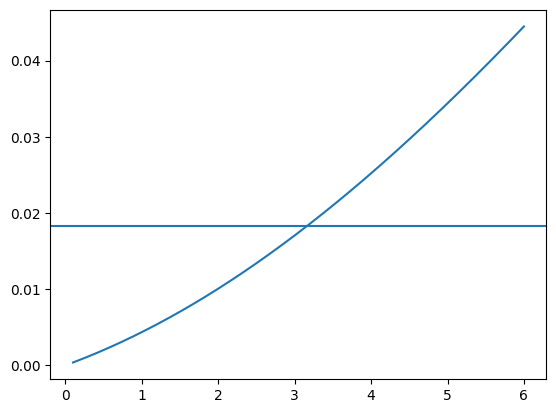

In [815]:
plt.plot(Ks,Ks*1/N**0.5*get_Fc(Ks,4000,m))
# plt.plot(Ks,1/Ks)
plt.axhline(1/N**0.5)

In [820]:
Ks[np.where(Ks*get_Fc(Ks,500,m=10)>1)][0]

5.7040133779264215

## K = 5, mc = 4.015, 이전 Km space data 사용

In [1]:
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import numpy as np
import TO_sim.Q_simul as QSIM
from tqdm.notebook import tqdm

In [2]:
import imp
imp.reload(QSIM)

<module 'TO_sim.Q_simul' from 'c:\\Users\\kim9y\\Desktop\\Kuramoto\\Kuramoto-model\\TO_sim\\Q_simul.py'>

In [11]:
seeds = np.arange(0,20)
df_mc = pd.DataFrame(columns=['r0','r+_total','r+','sig','sig+','N','m','K']).set_index('m')
df_mc_mean = pd.DataFrame(columns=['r0','r+_total','r+','sig','sig+','N','m','K']).set_index('m')

# Ensemble

In [7]:
import parmap
import TO_sim.parmap_use as PU
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [8]:
# seed,N,K,m_span,t_end,start_p
args = 10,500,5,(0.0,0.1,0.1),500,True
data = PU.MK_space(*args)

In [9]:
df = pd.DataFrame(columns=data.keys())

In [10]:
seeds = np.arange(48)
N = 3000
K = 5
m_span = (0,15,0.1)
t_end = 2000
core = 8
for i,data in enumerate(parmap.map(PU.MK_space,seeds,K=K,N=N,m_span =m_span,t_end=t_end,start_p=True,pm_pbar=True, pm_processes=core)):
    df.loc[i] = data

  0%|          | 0/48 [00:00<?, ?it/s]

In [8]:
ms = df['ms'][0]

S0 = np.array([*df['S0'].to_numpy()]).T
SP = np.array([*df['S+'].to_numpy()]).T
SM = np.array([*df['S-'].to_numpy()]).T

R0 = np.array([*df['r0'].to_numpy()]).T
RM0 = np.array([*df['rM'].to_numpy()]).T
RP = np.array([*df['r+'].to_numpy()]).T
RPT = np.array([*df['r+_total'].to_numpy()]).T
RM = np.array([*df['r-'].to_numpy()]).T
RMT = np.array([*df['r-_total'].to_numpy()]).T

V0 = np.array([*df['V0'].to_numpy()]).T
VP = np.array([*df['V+'].to_numpy()]).T
VM = np.array([*df['V-'].to_numpy()]).T

SIG = np.array([*df['sig'].to_numpy()]).T
SIGP = np.array([*df['sig_+total'].to_numpy()]).T
SIGM = np.array([*df['sig_-total'].to_numpy()]).T

S0_m = np.nanmean(S0,axis=1)
S0_std = np.nanstd(S0,axis=1)
SP_m = np.nanmean(SP,axis=1)
SP_std = np.nanstd(SP,axis=1)
SM_m = np.nanmean(SM,axis=1)
SM_std = np.nanstd(SM,axis=1)


R0_m = np.nanmean(R0,axis=1)
R0_std = np.nanstd(R0,axis=1)
RP_m = np.nanmean(RP,axis=1)
RP_std = np.nanstd(RP,axis=1)
RM_m = np.nanmean(RM,axis=1)
RM_std = np.nanstd(RM,axis=1)

In [ ]:
ms,S0,SP,SM,R0,RM0,RP,RPT,RM,RMT,V0,VP,VM,SIG,SIGP,SIGM

In [9]:
np.savez(f'./Ensembles/N = {N} K = {K}',ms=ms,S0=S0,SP=SP,SM=SM,R0=R0,RM0=RM0,RP=RP,RPT=RPT,RM=RM,RMT=RMT,SIG=SIG,V0=V0,VP=VP,VM=VM,SIGP=SIGP,SIGM=SIGM)

In [16]:
seeds = np.arange(48)
Ns = [250,500,2000,3000,4000]
for N in Ns:
# N = 1000
    K = 5
    m_span = (0,15,0.1)
    t_end = 2000
    core = 8
    df = pd.DataFrame(columns=data.keys())
    for i,data in enumerate(parmap.map(PU.MK_space,seeds,K=K,N=N,m_span =m_span,t_end=t_end,start_p=True,pm_pbar=True, pm_processes=core)):
        df.loc[i] = data
    ms = df['ms'][0]

    S0 = np.array([*df['S0'].to_numpy()]).T
    SP = np.array([*df['S+'].to_numpy()]).T
    SM = np.array([*df['S-'].to_numpy()]).T

    R0 = np.array([*df['r0'].to_numpy()]).T
    RM0 = np.array([*df['rM'].to_numpy()]).T
    RP = np.array([*df['r+'].to_numpy()]).T
    RPT = np.array([*df['r+_total'].to_numpy()]).T
    RM = np.array([*df['r-'].to_numpy()]).T
    RMT = np.array([*df['r-_total'].to_numpy()]).T

    V0 = np.array([*df['V0'].to_numpy()]).T
    VP = np.array([*df['V+'].to_numpy()]).T
    VM = np.array([*df['V-'].to_numpy()]).T

    SIG = np.array([*df['sig'].to_numpy()]).T
    SIGP = np.array([*df['sig_+total'].to_numpy()]).T
    SIGM = np.array([*df['sig_-total'].to_numpy()]).T

    S0_m = np.nanmean(S0,axis=1)
    S0_std = np.nanstd(S0,axis=1)
    SP_m = np.nanmean(SP,axis=1)
    SP_std = np.nanstd(SP,axis=1)
    SM_m = np.nanmean(SM,axis=1)
    SM_std = np.nanstd(SM,axis=1)


    R0_m = np.nanmean(R0,axis=1)
    R0_std = np.nanstd(R0,axis=1)
    RP_m = np.nanmean(RP,axis=1)
    RP_std = np.nanstd(RP,axis=1)
    RM_m = np.nanmean(RM,axis=1)
    RM_std = np.nanstd(RM,axis=1)
    np.savez(f'./Ensembles/N = {N} K = {K}',ms=ms,S0=S0,SP=SP,SM=SM,R0=R0,RM0=RM0,RP=RP,RPT=RPT,RM=RM,RMT=RMT,SIG=SIG,V0=V0,VP=VP,VM=VM,SIGP=SIGP,SIGM=SIGM)

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

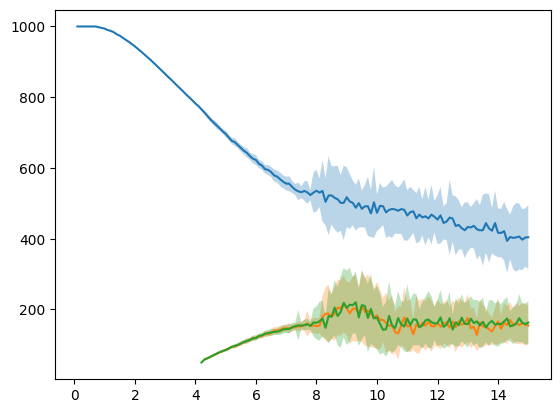

In [10]:
plt.plot(ms,S0_m)
plt.fill_between(ms,S0_m-S0_std,S0_m + S0_std,alpha=0.3)
plt.plot(ms,SP_m)
plt.fill_between(ms,SP_m-SP_std,SP_m + SP_std,alpha=0.3)
plt.plot(ms,SM_m)
plt.fill_between(ms,SM_m-SM_std,SM_m + SM_std,alpha=0.3)

In [12]:
df_Km = pd.read_excel('Order parameter and secondary cluster NEW.xlsm',index_col=[0,1])
df_K = df_Km.query('K == 5').reset_index().set_index('m')

In [13]:
import TO_sim.analytical.order_sec_parameter as OSP


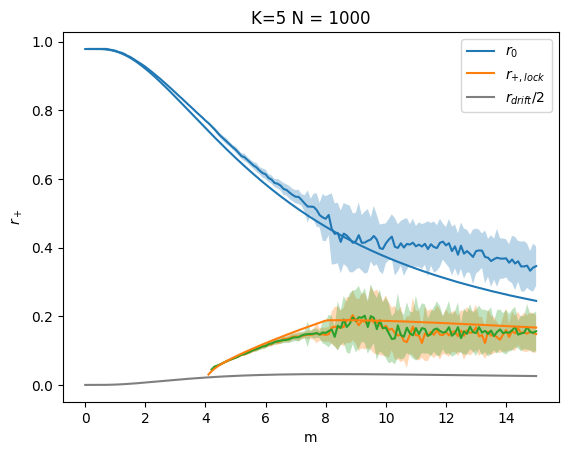

In [14]:
plt.plot(ms,R0_m)
plt.fill_between(ms,R0_m-R0_std,R0_m + R0_std,alpha=0.3)
plt.plot(ms,RP_m)
plt.fill_between(ms,RP_m-RP_std,RP_m + RP_std,alpha=0.3)
plt.plot(ms,RM_m)
plt.fill_between(ms,RM_m-RM_std,RM_m + RM_std,alpha=0.3)


plt.plot(df_K['r0_u'],color ='tab:blue',label='$r_0$',zorder=10)
plt.plot(df_K['r+_ul'],color ='tab:orange',label='$r_{+,lock}$',zorder=10)
plt.plot(df_K['r+_drift'],color ='tab:grey',label='$r_{drift}/2$',zorder=10)
ms_ = df_K.index.to_numpy(float)
rstd = OSP.get_rstd(df_K['r0_u'].to_numpy(float),df_K['r+_ul'].to_numpy(float),5,ms_)


plt.legend()
# plt.axvline(Ks_check2[~np.isnan(mu)][0]
plt.title(f'K={K} N = {N}')
plt.xlabel(f'm')
plt.ylabel(f'$r_+$')

plt.legend()

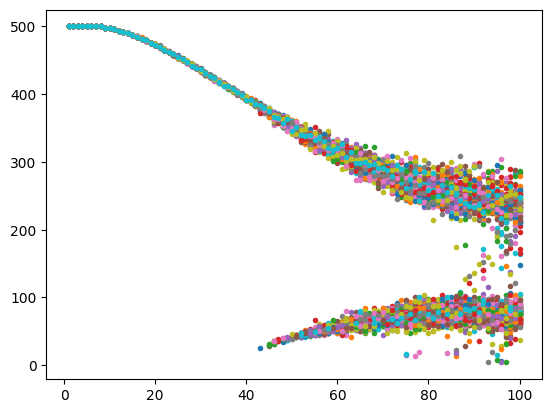

In [47]:
# plt.plot(np.array([*df['r0'].to_numpy()]).T[0],'.')
# plt.plot(np.array([*df['r+'].to_numpy()]).T[0],'.')
# plt.plot(np.array([*df['r+'].to_numpy()]).T[0],'.')
plt.plot(np.array([*df['S0'].to_numpy()]).T,'.');
plt.plot(np.array([*df['S+'].to_numpy()]).T,'.');
plt.plot(np.array([*df['S-'].to_numpy()]).T,'.');

In [30]:
np.array([*df['S0'].to_numpy()]).T.shape

(101, 50)

In [27]:
df['S0']

0     [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
1     [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
2     [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
3     [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
4     [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
5     [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
6     [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
7     [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
8     [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
9     [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
10    [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
11    [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
12    [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
13    [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
14    [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
15    [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
16    [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0...
17    [nan, 500.0, 500.0, 500.0, 500.0, 500.0, 5

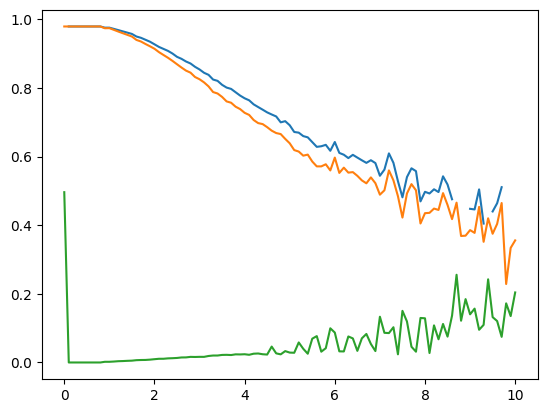

In [7]:
plt.plot(data['ms'],data['r0'])
plt.plot(data['ms'],data['rM'])
plt.plot(data['ms'],data['r+_total'])

In [ ]:
N = 1000
K = 4.1
seeds = np.arange(50)
m = 4.1
df_m5 = pd.DataFrame(columns=['r0','rM',],index=seeds)
m_span = 2,10,0.1
for seed in parmap.map(PU.MK_space,seeds,N,m_span,t_end,start_p):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=3000,seed=seed,start_p=True)
    KM_info = Qsimul.MK_space(2,10,0.1)
    df_m5.loc[seed]['KM_info'] = KM_info

In [148]:
N = 1000
K = 4.1
seeds = np.arange(50)
m = 4.1
df_m5 = pd.DataFrame(columns=['KM_info'],index=seeds)
# for seed in tqdm(seeds):
for seed in tqdm(seeds):
    Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=3000,seed=seed,start_p=True)
    KM_info = Qsimul.MK_space(2,10,0.1)
    df_m5.loc[seed]['KM_info'] = KM_info

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [142]:
df_Km = pd.read_excel('Order parameter and secondary cluster NEW.xlsm',index_col=[0,1])
df_K = df_Km.query('4.0<K<=4.11').reset_index().set_index('m')

In [143]:
df_K

,K,rM_u,rM_d,r0_u,r0_d,rd_u,rd_d,r+_ul,r+_drift,mu,r+_total_u,r+_total_d,r+_total_ul,r+_total_ud
m,,,,,,,,,,,,,,
0.0,4.1,0.966248,0.966248,0.966248,0.966248,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
0.1,4.1,0.966236,NaN,0.966248,NaN,0.000013,NaN,NaN,0.000006,NaN,NaN,NaN,NaN,NaN
0.2,4.1,0.966229,NaN,0.966247,NaN,0.000018,NaN,NaN,0.000009,NaN,NaN,NaN,NaN,NaN
0.3,4.1,0.966146,NaN,0.966201,NaN,0.000055,NaN,NaN,0.000028,NaN,NaN,NaN,NaN,NaN
0.4,4.1,0.965797,NaN,0.965968,NaN,0.000171,NaN,NaN,0.000086,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.6,4.1,0.147923,0.010057,0.193451,0.025483,0.045528,0.015426,0.162463,0.022764,NaN,0.162463,NaN,NaN,NaN
14.7,4.1,0.146840,0.009922,0.192170,0.025220,0.045330,0.015299,0.161919,0.022665,NaN,0.161919,NaN,NaN,NaN
14.8,4.1,0.145503,0.009773,0.190594,0.024939,0.045091,0.015166,0.161368,0.022546,NaN,0.161368,NaN,NaN,NaN


In [ ]:
df_Km_old = pd.read_excel('Order parameter and secondary cluster NEW.xlsm',index_col=[0,1])
df_K5_old = df_Km.query('K==5').reset_index().set_index('m')

In [17]:
import matplotlib.pyplot as plt

In [100]:
import TO_sim.analytical.order_sec_parameter as OSP

In [103]:
ms = df_K5.index

In [144]:
rstd = OSP.get_rstd(df_K['rM_u'].to_numpy(float),df_K['r+_ul'].to_numpy(float),4.1,ms.to_numpy(float))


In [133]:
KM_info

{'ms': array([ 2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,
         3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,
         4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,
         5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,
         6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,
         7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,
         8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,
         9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7,
        10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8,
        11.9, 12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9,
        13. , 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. ,
        14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. ]),
 'r_info':         r_mean        r0        r+        r-  r+_total  r-_total  sig_mean  \
 2.0   0.911386  0.92

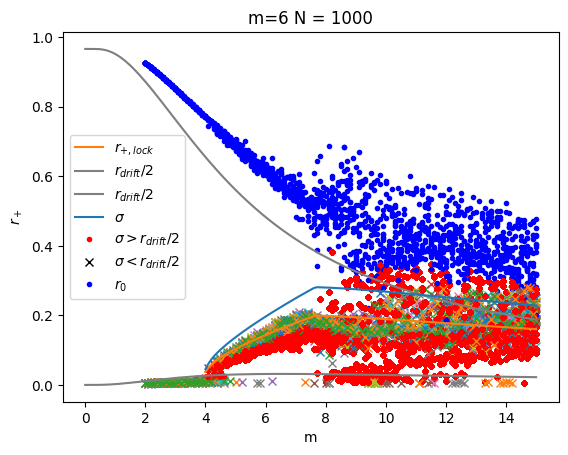

In [145]:
plt.plot(df_K['r+_ul'],color ='tab:orange',label='$r_{+,lock}$',zorder=10)
plt.plot(df_K['r+_drift'],color ='tab:grey',label='$r_{drift}/2$',zorder=10)
plt.plot(df_K['r0_u'],color ='tab:grey',label='$r_{drift}/2$',zorder=10)
rstd = OSP.get_rstd(df_K['r0_u'].to_numpy(float),df_K['r+_ul'].to_numpy(float),5,ms.to_numpy(float))

plt.plot(ms,rstd,color ='tab:blue',label='$\sigma$',zorder=10)

for seed in seeds[:13]:
    KM_info = df_m5.loc[seed]['KM_info']
    ms_ = KM_info['ms']
    rmm = KM_info['r_info'][['r-_total']].to_numpy(float)
    rm_ = KM_info['r_info'][['r-']].to_numpy(float)
    r0 = KM_info['r_info'][['r0']].to_numpy(float)
    sig = KM_info['r_info'][['sig_mean']].to_numpy(float)
    sigPT = KM_info['r_info'][['sig+_total']].to_numpy(float)
    index_ = np.searchsorted(df_K.index,ms_)

    rm = np.where(sig>df_K.query('2.0<=m<=12.0')['r+_drift'].to_numpy(float),rmm,np.nan)
    rnot_m = np.where(sig>df_K.query('2.0<=m<=12.0')['r+_drift'].to_numpy(float),np.nan,rmm)
    plt.plot(ms_,sig,'x')
    plt.plot(ms_,rm,'.',color='red')
    plt.plot(ms_,r0,'.',color='blue')
    # plt.plot(ms_,rm,'s',color='red')
    # plt.plot(ms_,rm_,'s',color='tab:orange')
    # plt.plot(ms_,rnot_m,'x',color='black')
    # plt.plot(ms_,sigPT,'x',color='tab:blue')
plt.plot(np.nan,np.nan,'r.',label='$\sigma>r_{drift}/2$')
plt.plot(np.nan,np.nan,'kx',label='$\sigma<r_{drift}/2$')
plt.plot(np.nan,np.nan,'b.',label='$r_0$')
plt.legend()
# plt.axvline(Ks_check2[~np.isnan(mu)][0]
plt.title(f'm={m} N = {N}')
plt.xlabel(f'm')
plt.ylabel(f'$r_+$')


plt.legend()

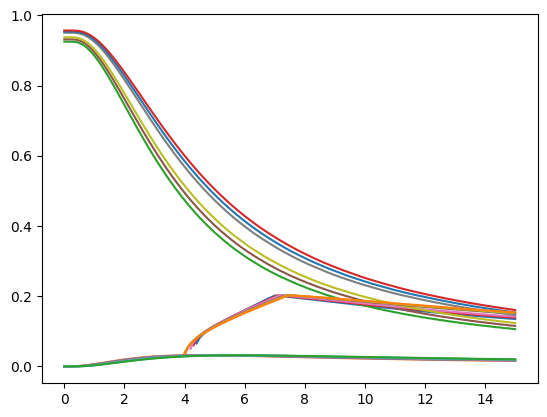

In [86]:
for K in Ks[30:40:1] :
    df_Km = pd.read_excel('Order parameter and secondary cluster NEW.xlsm',index_col=[0,1])
    df_K5 = df_Km.query(f'K=={K}').reset_index().set_index('m')
    plt.plot(df_K5['r+_ul'],label='$r_{+,lock}$')
    plt.plot(df_K5['r+_drift'],label='$r_{drift}/2$')
    plt.plot(df_K5['r0_u'],label='$r_{drift}/2$')


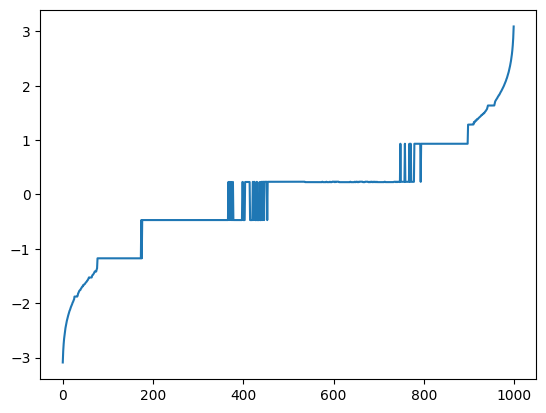

In [70]:
# plt.plot(KM_info['avg_dtheta'].iloc[120])
# plt.plot(KM_info['avg_dtheta'].iloc[110])
plt.plot(KM_info['avg_dtheta'].iloc[130])
# plt.plot(KM_info['avg_dtheta'].iloc[90])
# plt.plot(KM_info['avg_dtheta'].iloc[80])

In [55]:
KM_info['avg_dtheta'].iloc[112]

0     -3.089807
1     -2.878088
2     -2.747281
3     -2.651632
4     -2.575407
         ...   
995    2.576438
996    2.651577
997    2.747351
998    2.877928
999    3.090213
Name: 13.20000000000001, Length: 1000, dtype: object

In [88]:
m = 10 # 5.5
F_RMd4,F_RMu4,F_R0d4,F_R0u4 =  OSP2.Make_R_function(m)

# Ks_check2 = np.arange(4.36,4.38,0.001)
Ks_check2 = np.arange(0,10,0.2)
rs_d_NEW,rs_u_NEW,rs_dFl_NEW,rs_uFl_NEW,md,mu = OSP2.get_r_sec_np(Ks_check2,m,F_RMd4,samples=50)

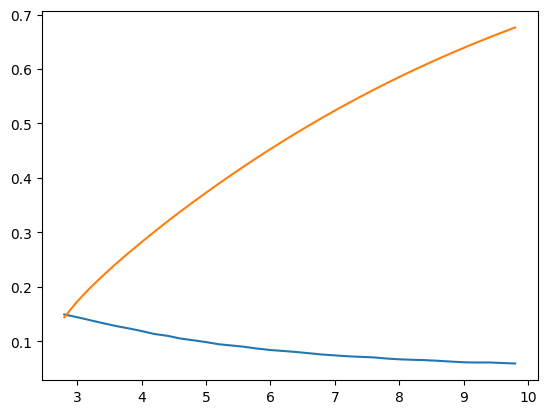

In [90]:
plt.plot(Ks_check2,rs_uFl_NEW)
plt.plot(Ks_check2,F_R0u4(Ks_check2))

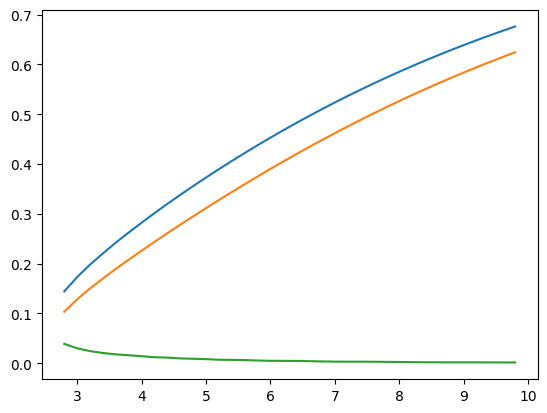

In [94]:
plt.plot(Ks_check2,F_R0u4(Ks_check2))
plt.plot(Ks_check2,F_RMu4(Ks_check2))
plt.plot(Ks_check2,F_RMd4(Ks_check2))
